Import important parameter

In [1]:
inputsize = 97
e = 0.0125

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 2.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 2.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
MAX_ITER = 50
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/2)
h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 2.*np.transpose(R)

In [5]:
num_levels = 2
n = inputsize
linear_gmg = gmg_linear.LinearGMG(A1, max_levels=num_levels)
print("Linear = {}".format(linear_gmg.compute_rho()))

Linear = 0.6794264803170181


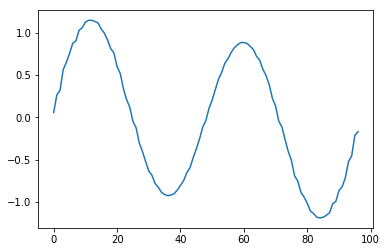

In [6]:
gmmx = linear_gmg.solve(RightF,np.zeros(A1.shape),tol=1e-12)
plt.plot(gmmx)

In [7]:
print("Relative error = {}".format(np.linalg.norm(gmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 0.18099718247157157


Local DMM on fine grid

In [8]:
K = 10
batch_size = 10
num_iter = 4000
step_size = 5e-5
PR_stencil_type = "m3p"
init_point = None
convergence = {}
opt_par_n = {}
conv_time = {}
deep_gmm = dgmg.DeepMG(A1, K=K, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
opt_par = deep_gmm.optimize(num_iter=num_iter, step_size=step_size, batch_size=batch_size, init_point=init_point)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/4000
Upper bound estimation = 0.7573547121646514
Iteration 200/4000
Upper bound estimation = 0.7301503270249802
Iteration 300/4000
Upper bound estimation = 0.6895959392871631
Iteration 400/4000
Upper bound estimation = 0.670272014383001
Iteration 500/4000
Upper bound estimation = 0.6666289259884419
Iteration 600/4000
Upper bound estimation = 0.6400015666980602
Iteration 700/4000
Upper bound estimation = 0.630799934450922
Iteration 800/4000
Upper bound estimation = 0.6022543182008155
Iteration 900/4000
Upper bound estimation = 0.5852750933445672
Iteration 1000/4000
Upper bound estimation = 0.5608107074436072
Iteration 1100/4000
Upper bound estimation = 0.5453755101011776
Iteration 1200/4000
Upper bound estimation = 0.5071159506327985
Iteration 1300/4000
Upper bound estimation = 0.4846715543475376
Iteration 1400/4000
Upper bound estimation = 0.472171264468532
Iteration 1500/4000
Upper bound estimation = 0.45625703825217534
Iteration 1600/4000
Upper bound estimation = 0.4248

In [9]:
deep_gmm.update_prd(opt_par)  
current_rho = deep_gmm.compute_rho()
print("Optimized rho = {}".format(current_rho))

Optimized rho = 0.2094426505345574


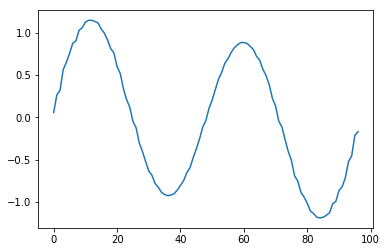

In [10]:
dmmx = deep_gmm.solve(RightF,np.zeros(A1.shape) ,tol=1e-12)
plt.plot(gmmx)

In [11]:
print("Relative error = {}".format(np.linalg.norm(dmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 0.18099718247251448


In [12]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-6,accept_radius = 1 ,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.12076522202319773
L = 0.03
rho = 0.12175791932404686
L = 0.04
rho = 0.12302870230797203
L = 0.05
rho = 0.12442378917028973
L = 0.060000000000000005
rho = 0.12588752469644487
L = 0.07
rho = 0.12740056837543465
L = 0.08
rho = 0.12895588302018426
L = 0.09
rho = 0.13055086957616155
L = 0.09999999999999999
rho = 0.13218469675374717
L = 0.10999999999999999
rho = 0.13385727186689325
L = 0.11999999999999998
rho = 0.13556877115402113
L = 0.12999999999999998
rho = 0.13731938817464998
L = 0.13999999999999999
rho = 0.13910918488630422
L = 0.15
rho = 0.1409380031954195
L = 0.16
rho = 0.1428054195422553
L = 0.17
rho = 0.14471073309958699
L = 0.18000000000000002
rho = 0.14665298013903597
L = 0.19000000000000003
rho = 0.14863096722549313
L = 0.20000000000000004
rho = 0.150643315921174
L = 0.21000000000000005
rho = 0.15268851227328803
L = 0.22000000000000006
rho = 0.15476495556816333
L = 0.23000000000000007
rho = 0.15687100240786644
L = 0.24000000000000007
rho = 0

the 38 steps
rho = 0.33830359772469654
the 39 steps
rho = 0.338278379234797
the 40 steps
rho = 0.33825346070089723
the 41 steps
rho = 0.33822883471274123
the 42 steps
rho = 0.33820449413464015
the 43 steps
rho = 0.338180432091468
the 44 steps
rho = 0.33815664195551104
the 45 steps
rho = 0.33813311733417006
the 46 steps
rho = 0.3381098520584199
the 47 steps
rho = 0.3380868401719894
the 48 steps
rho = 0.338064075921209
the 49 steps
rho = 0.33804155374543743
the 50 steps
rho = 0.33801926826810097
the 51 steps
rho = 0.33799721428825097
the 52 steps
rho = 0.33797538677260436
the 53 steps
rho = 0.337953780848048
the 54 steps
rho = 0.3379323917945897
the 55 steps
rho = 0.33791121503867944
the 56 steps
rho = 0.33789024614693713
the 57 steps
rho = 0.3378694808201889
the 58 steps
rho = 0.3378489148878801
the 59 steps
rho = 0.33782854430273557
the 60 steps
rho = 0.33780836513574913
the 61 steps
rho = 0.3377883735714127
the 62 steps
rho = 0.3377685659032169
the 63 steps
rho = 0.3377489385293586
th

the 192 steps
rho = 0.3360383422218133
the 193 steps
rho = 0.3360285979697647
the 194 steps
rho = 0.3360188842440452
the 195 steps
rho = 0.33600920075381147
the 196 steps
rho = 0.3359995472122965
the 197 steps
rho = 0.33598992333670813
the 198 steps
rho = 0.3359803288481905
the 199 steps
rho = 0.33597076347173305
the 200 steps
rho = 0.3359612269361166
the 201 steps
rho = 0.33595171897384385
the 202 steps
rho = 0.3359422393210732
the 203 steps
rho = 0.3359327877175613
the 204 steps
rho = 0.33592336390660205
the 205 steps
rho = 0.33591396763496173
the 206 steps
rho = 0.3359045986528162
the 207 steps
rho = 0.33589525671371223
the 208 steps
rho = 0.33588594157448654
the 209 steps
rho = 0.3358766529952223
the 210 steps
rho = 0.33586739073919974
the 211 steps
rho = 0.33585815457284424
the 212 steps
rho = 0.3358489442656438
the 213 steps
rho = 0.3358397595901494
the 214 steps
rho = 0.3358306003218689
the 215 steps
rho = 0.3358214662392712
the 216 steps
rho = 0.3358123571236963
the 217 steps
r

the 342 steps
rho = 0.3348118743312614
the 343 steps
rho = 0.3348048086259477
the 344 steps
rho = 0.3347977534070374
the 345 steps
rho = 0.33479070861947746
the 346 steps
rho = 0.3347836742086941
the 347 steps
rho = 0.3347766501205896
the 348 steps
rho = 0.3347696363015219
the 349 steps
rho = 0.3347626326983197
the 350 steps
rho = 0.3347556392582624
the 351 steps
rho = 0.3347486559290786
the 352 steps
rho = 0.33474168265894505
the 353 steps
rho = 0.3347347193964784
the 354 steps
rho = 0.3347277660907277
the 355 steps
rho = 0.3347208226911768
the 356 steps
rho = 0.33471388914773
the 357 steps
rho = 0.33470696541071476
the 358 steps
rho = 0.3347000514308753
the 359 steps
rho = 0.33469314715936554
the 360 steps
rho = 0.33468625254774736
the 361 steps
rho = 0.3346793675479837
the 362 steps
rho = 0.334672492112438
the 363 steps
rho = 0.33466562619386037
the 364 steps
rho = 0.3346587697453974
the 365 steps
rho = 0.33465192272058103
the 366 steps
rho = 0.3346450850733148
the 367 steps
rho = 0

the 492 steps
rho = 0.33384609647995184
the 493 steps
rho = 0.33384017293046386
the 494 steps
rho = 0.33383425496454866
the 495 steps
rho = 0.3338283425634875
the 496 steps
rho = 0.33382243570867554
the 497 steps
rho = 0.33381653438161624
the 498 steps
rho = 0.33381063856392085
the 499 steps
rho = 0.33380474823731343
the 500 steps
rho = 0.33379886338362064
the 501 steps
rho = 0.33379298398478346
the 502 steps
rho = 0.3337871100228407
the 503 steps
rho = 0.33378124147994065
the 504 steps
rho = 0.33377537833833415
the 505 steps
rho = 0.33376952058037673
the 506 steps
rho = 0.3337636681885303
the 507 steps
rho = 0.3337578211453522
the 508 steps
rho = 0.3337519794335024
the 509 steps
rho = 0.333746143035742
the 510 steps
rho = 0.3337403119349314
the 511 steps
rho = 0.33373448611403234
the 512 steps
rho = 0.3337286655561001
the 513 steps
rho = 0.33372285024428966
the 514 steps
rho = 0.3337170401618547
the 515 steps
rho = 0.33371123529213687
the 516 steps
rho = 0.3337054356185774
the 517 ste

the 646 steps
rho = 0.3329904986122728
the 647 steps
rho = 0.3329852653170263
the 648 steps
rho = 0.33298003564750783
the 649 steps
rho = 0.33297480959525083
the 650 steps
rho = 0.3329695871518315
the 651 steps
rho = 0.33296436830885856
the 652 steps
rho = 0.33295915305798107
the 653 steps
rho = 0.3329539413908847
the 654 steps
rho = 0.33294873329929575
the 655 steps
rho = 0.33294352877496847
the 656 steps
rho = 0.33293832780970123
the 657 steps
rho = 0.33293313039532585
the 658 steps
rho = 0.3329279365237116
the 659 steps
rho = 0.3329227461867588
the 660 steps
rho = 0.3329175593764133
the 661 steps
rho = 0.33291237608464497
the 662 steps
rho = 0.33290719630347193
the 663 steps
rho = 0.33290202002493263
the 664 steps
rho = 0.33289684724110985
the 665 steps
rho = 0.33289167794411895
the 666 steps
rho = 0.33288651212610965
the 667 steps
rho = 0.3328813497792648
the 668 steps
rho = 0.3328761908958032
the 669 steps
rho = 0.33287103546797764
the 670 steps
rho = 0.33286588348807034
the 671 s

the 784 steps
rho = 0.3322994227606583
the 785 steps
rho = 0.3322946232963545
the 786 steps
rho = 0.33228982657020545
the 787 steps
rho = 0.33228503257738445
the 788 steps
rho = 0.33228024131308465
the 789 steps
rho = 0.3322754527725123
the 790 steps
rho = 0.33227066695089913
the 791 steps
rho = 0.33226588384349076
the 792 steps
rho = 0.33226110344554416
the 793 steps
rho = 0.3322563257523409
the 794 steps
rho = 0.33225155075917473
the 795 steps
rho = 0.3322467784613687
the 796 steps
rho = 0.33224200885424354
the 797 steps
rho = 0.3322372419331565
the 798 steps
rho = 0.33223247769346675
the 799 steps
rho = 0.3322277161305588
the 800 steps
rho = 0.33222295723983225
the 801 steps
rho = 0.33221820101670213
the 802 steps
rho = 0.3322134474565997
the 803 steps
rho = 0.33220869655497526
the 804 steps
rho = 0.3322039483072958
the 805 steps
rho = 0.33219920270904213
the 806 steps
rho = 0.3321944597557135
the 807 steps
rho = 0.33218971944282105
the 808 steps
rho = 0.33218498176589817
the 809 st

the 932 steps
rho = 0.33161663273512737
the 933 steps
rho = 0.3316121940299216
the 934 steps
rho = 0.331607757504622
the 935 steps
rho = 0.33160332315631236
the 936 steps
rho = 0.33159889098208173
the 937 steps
rho = 0.3315944609790297
the 938 steps
rho = 0.33159003314426283
the 939 steps
rho = 0.3315856074748987
the 940 steps
rho = 0.3315811839680627
the 941 steps
rho = 0.33157676262088764
the 942 steps
rho = 0.3315723434305213
the 943 steps
rho = 0.3315679263941129
the 944 steps
rho = 0.3315635115088228
the 945 steps
rho = 0.3315590987718255
the 946 steps
rho = 0.33155468818029343
the 947 steps
rho = 0.33155027973141743
the 948 steps
rho = 0.33154587342239267
the 949 steps
rho = 0.33154146925042205
the 950 steps
rho = 0.3315370672127201
the 951 steps
rho = 0.3315326673065075
the 952 steps
rho = 0.33152826952901465
the 953 steps
rho = 0.33152387387747745
the 954 steps
rho = 0.3315194803491442
the 955 steps
rho = 0.331515088941272
the 956 steps
rho = 0.3315106996511187
the 957 steps
rh

the 1076 steps
rho = 0.33099861990983775
the 1077 steps
rho = 0.3309944688901947
the 1078 steps
rho = 0.3309903197074219
the 1079 steps
rho = 0.3309861723595864
the 1080 steps
rho = 0.3309820268447563
the 1081 steps
rho = 0.330977883161011
the 1082 steps
rho = 0.3309737413064284
the 1083 steps
rho = 0.3309696012790986
the 1084 steps
rho = 0.33096546307710606
the 1085 steps
rho = 0.33096132669855105
the 1086 steps
rho = 0.3309571921415323
the 1087 steps
rho = 0.33095305940415537
the 1088 steps
rho = 0.3309489284845339
the 1089 steps
rho = 0.3309447993807765
the 1090 steps
rho = 0.3309406720910094
the 1091 steps
rho = 0.3309365466133565
the 1092 steps
rho = 0.3309324229459468
the 1093 steps
rho = 0.3309283010869113
the 1094 steps
rho = 0.3309241810343954
the 1095 steps
rho = 0.33092006278653907
the 1096 steps
rho = 0.3309159463414924
the 1097 steps
rho = 0.3309118316974106
the 1098 steps
rho = 0.33090771885245135
the 1099 steps
rho = 0.33090360780477357
the 1100 steps
rho = 0.33089949855

the 1225 steps
rho = 0.3303994155623246
the 1226 steps
rho = 0.3303955192901357
the 1227 steps
rho = 0.33039162461307986
the 1228 steps
rho = 0.3303877315297967
the 1229 steps
rho = 0.3303838400389335
the 1230 steps
rho = 0.33037995013912763
the 1231 steps
rho = 0.3303760618290365
the 1232 steps
rho = 0.33037217510730477
the 1233 steps
rho = 0.3303682899725892
the 1234 steps
rho = 0.3303644064235485
the 1235 steps
rho = 0.33036052445883923
the 1236 steps
rho = 0.33035664407712034
the 1237 steps
rho = 0.33035276527706775
the 1238 steps
rho = 0.33034888805734397
the 1239 steps
rho = 0.3303450124166144
the 1240 steps
rho = 0.3303411383535593
the 1241 steps
rho = 0.33033726586685475
the 1242 steps
rho = 0.33033339495517683
the 1243 steps
rho = 0.3303295256172118
the 1244 steps
rho = 0.33032565785163565
the 1245 steps
rho = 0.33032179165714676
the 1246 steps
rho = 0.33031792703242585
the 1247 steps
rho = 0.3303140639761714
the 1248 steps
rho = 0.3303102024870761
the 1249 steps
rho = 0.33030

the 1375 steps
rho = 0.32983210305501837
the 1376 steps
rho = 0.32982843224720304
the 1377 steps
rho = 0.32982476285758067
the 1378 steps
rho = 0.32982109488512945
the 1379 steps
rho = 0.3298174283288207
the 1380 steps
rho = 0.32981376318763667
the 1381 steps
rho = 0.3298100994605514
the 1382 steps
rho = 0.3298064371465481
the 1383 steps
rho = 0.3298027762446063
the 1384 steps
rho = 0.3297991167537118
the 1385 steps
rho = 0.3297954586728496
the 1386 steps
rho = 0.32979180200100505
the 1387 steps
rho = 0.32978814673717094
the 1388 steps
rho = 0.32978449288033246
the 1389 steps
rho = 0.3297808404294842
the 1390 steps
rho = 0.32977718938361944
the 1391 steps
rho = 0.32977353974173346
the 1392 steps
rho = 0.3297698915028217
the 1393 steps
rho = 0.32976624466588284
the 1394 steps
rho = 0.32976259922992135
the 1395 steps
rho = 0.3297589551939298
the 1396 steps
rho = 0.3297553125569171
the 1397 steps
rho = 0.3297516713178904
the 1398 steps
rho = 0.32974803147585147
the 1399 steps
rho = 0.3297

the 1514 steps
rho = 0.3293350361133479
the 1515 steps
rho = 0.3293315532511625
the 1516 steps
rho = 0.3293280716784347
the 1517 steps
rho = 0.3293245913943218
the 1518 steps
rho = 0.32932111239798934
the 1519 steps
rho = 0.32931763468859804
the 1520 steps
rho = 0.32931415826531324
the 1521 steps
rho = 0.32931068312729894
the 1522 steps
rho = 0.32930720927372364
the 1523 steps
rho = 0.32930373670375046
the 1524 steps
rho = 0.32930026541654883
the 1525 steps
rho = 0.329296795411287
the 1526 steps
rho = 0.3292933266871397
the 1527 steps
rho = 0.32928985924327453
the 1528 steps
rho = 0.32928639307886276
the 1529 steps
rho = 0.32928292819308264
the 1530 steps
rho = 0.3292794645851028
the 1531 steps
rho = 0.32927600225410086
the 1532 steps
rho = 0.32927254119925436
the 1533 steps
rho = 0.32926908141973876
the 1534 steps
rho = 0.32926562291473105
the 1535 steps
rho = 0.32926216568341593
the 1536 steps
rho = 0.32925870972496796
the 1537 steps
rho = 0.32925525503857167
the 1538 steps
rho = 0.3

the 1652 steps
rho = 0.3288662448169151
the 1653 steps
rho = 0.32886293237535724
the 1654 steps
rho = 0.3288596211161537
the 1655 steps
rho = 0.32885631103858387
the 1656 steps
rho = 0.32885300214192886
the 1657 steps
rho = 0.32884969442546597
the 1658 steps
rho = 0.3288463878884799
the 1659 steps
rho = 0.3288430825302524
the 1660 steps
rho = 0.3288397783500671
the 1661 steps
rho = 0.3288364753472021
the 1662 steps
rho = 0.3288331735209504
the 1663 steps
rho = 0.328829872870589
the 1664 steps
rho = 0.32882657339540783
the 1665 steps
rho = 0.3288232750946919
the 1666 steps
rho = 0.3288199779677292
the 1667 steps
rho = 0.328816682013807
the 1668 steps
rho = 0.3288133872322107
the 1669 steps
rho = 0.3288100936222333
the 1670 steps
rho = 0.32880680118316163
the 1671 steps
rho = 0.3288035099142862
the 1672 steps
rho = 0.32880021981490015
the 1673 steps
rho = 0.3287969308842924
the 1674 steps
rho = 0.3287936431217588
the 1675 steps
rho = 0.32879035652658767
the 1676 steps
rho = 0.32878707109

the 1798 steps
rho = 0.3283947890628729
the 1799 steps
rho = 0.3283916419360612
the 1800 steps
rho = 0.3283884958928201
the 1801 steps
rho = 0.32838535093251425
the 1802 steps
rho = 0.328382207054508
the 1803 steps
rho = 0.328379064258162
the 1804 steps
rho = 0.328375922542841
the 1805 steps
rho = 0.3283727819079086
the 1806 steps
rho = 0.3283696423527313
the 1807 steps
rho = 0.3283665038766706
the 1808 steps
rho = 0.3283633664791018
the 1809 steps
rho = 0.3283602301593777
the 1810 steps
rho = 0.32835709491687504
the 1811 steps
rho = 0.3283539607509577
the 1812 steps
rho = 0.3283508276609929
the 1813 steps
rho = 0.3283476956463494
the 1814 steps
rho = 0.32834456470639845
the 1815 steps
rho = 0.3283414348405016
the 1816 steps
rho = 0.32833830604803305
the 1817 steps
rho = 0.3283351783283668
the 1818 steps
rho = 0.32833205168086477
the 1819 steps
rho = 0.3283289261049027
the 1820 steps
rho = 0.3283258015998515
the 1821 steps
rho = 0.3283226781650815
the 1822 steps
rho = 0.328319555799967

the 1937 steps
rho = 0.32796745831406227
the 1938 steps
rho = 0.3279644558793385
the 1939 steps
rho = 0.32796145444362423
the 1940 steps
rho = 0.3279584540063408
the 1941 steps
rho = 0.3279554545669068
the 1942 steps
rho = 0.3279524561247438
the 1943 steps
rho = 0.3279494586792682
the 1944 steps
rho = 0.32794646222990004
the 1945 steps
rho = 0.3279434667760599
the 1946 steps
rho = 0.32794047231716894
the 1947 steps
rho = 0.3279374788526464
the 1948 steps
rho = 0.32793448638191414
the 1949 steps
rho = 0.3279314949043964
the 1950 steps
rho = 0.32792850441951105
the 1951 steps
rho = 0.32792551492668076
the 1952 steps
rho = 0.3279225264253313
the 1953 steps
rho = 0.3279195389148829
the 1954 steps
rho = 0.3279165523947596
the 1955 steps
rho = 0.3279135668643838
the 1956 steps
rho = 0.32791058232318226
the 1957 steps
rho = 0.3279075987705751
the 1958 steps
rho = 0.3279046162059887
the 1959 steps
rho = 0.3279016346288516
the 1960 steps
rho = 0.3278986540385851
the 1961 steps
rho = 0.327895674

the 2078 steps
rho = 0.3275537145403438
the 2079 steps
rho = 0.32755084737614487
the 2080 steps
rho = 0.3275479811321376
the 2081 steps
rho = 0.3275451158077775
the 2082 steps
rho = 0.32754225140253257
the 2083 steps
rho = 0.32753938791586157
the 2084 steps
rho = 0.3275365253472286
the 2085 steps
rho = 0.3275336636960986
the 2086 steps
rho = 0.32753080296193243
the 2087 steps
rho = 0.32752794314419825
the 2088 steps
rho = 0.3275250842423562
the 2089 steps
rho = 0.32752222625587196
the 2090 steps
rho = 0.3275193691842142
the 2091 steps
rho = 0.32751651302684
the 2092 steps
rho = 0.3275136577832227
the 2093 steps
rho = 0.3275108034528222
the 2094 steps
rho = 0.3275079500351067
the 2095 steps
rho = 0.3275050975295422
the 2096 steps
rho = 0.32750224593559546
the 2097 steps
rho = 0.32749939525273425
the 2098 steps
rho = 0.32749654548042106
the 2099 steps
rho = 0.3274936966181287
the 2100 steps
rho = 0.32749084866532224
the 2101 steps
rho = 0.3274880016214664
the 2102 steps
rho = 0.327485155

the 2218 steps
rho = 0.32716102846869427
the 2219 steps
rho = 0.3271582850194862
the 2220 steps
rho = 0.3271555424177816
the 2221 steps
rho = 0.3271528006630765
the 2222 steps
rho = 0.3271500597548722
the 2223 steps
rho = 0.32714731969266725
the 2224 steps
rho = 0.3271445804759653
the 2225 steps
rho = 0.3271418421042596
the 2226 steps
rho = 0.3271391045770567
the 2227 steps
rho = 0.32713636789385087
the 2228 steps
rho = 0.3271336320541447
the 2229 steps
rho = 0.3271308970574417
the 2230 steps
rho = 0.3271281629032413
the 2231 steps
rho = 0.3271254295910427
the 2232 steps
rho = 0.32712269712034936
the 2233 steps
rho = 0.3271199654906629
the 2234 steps
rho = 0.3271172347014863
the 2235 steps
rho = 0.32711450475232084
the 2236 steps
rho = 0.32711177564266775
the 2237 steps
rho = 0.32710904737203117
the 2238 steps
rho = 0.32710631993991424
the 2239 steps
rho = 0.3271035933458183
the 2240 steps
rho = 0.3271008675892519
the 2241 steps
rho = 0.3270981426697126
the 2242 steps
rho = 0.327095418

the 2367 steps
rho = 0.3267613330930798
the 2368 steps
rho = 0.32675871052568795
the 2369 steps
rho = 0.32675608873375384
the 2370 steps
rho = 0.3267534677168129
the 2371 steps
rho = 0.3267508474743978
the 2372 steps
rho = 0.3267482280060448
the 2373 steps
rho = 0.3267456093112845
the 2374 steps
rho = 0.32674299138965673
the 2375 steps
rho = 0.3267403742406936
the 2376 steps
rho = 0.3267377578639305
the 2377 steps
rho = 0.32673514225890343
the 2378 steps
rho = 0.3267325274251472
the 2379 steps
rho = 0.32672991336219853
the 2380 steps
rho = 0.32672730006959266
the 2381 steps
rho = 0.3267246875468681
the 2382 steps
rho = 0.326722075793559
the 2383 steps
rho = 0.32671946480920433
the 2384 steps
rho = 0.3267168545933404
the 2385 steps
rho = 0.32671424514550457
the 2386 steps
rho = 0.32671163646523205
the 2387 steps
rho = 0.326709028552065
the 2388 steps
rho = 0.326706421405537
the 2389 steps
rho = 0.32670381502518947
the 2390 steps
rho = 0.32670120941055636
the 2391 steps
rho = 0.326698604

the 2519 steps
rho = 0.32637133935980533
the 2520 steps
rho = 0.3263688294416626
the 2521 steps
rho = 0.32636632023068984
the 2522 steps
rho = 0.3263638117264599
the 2523 steps
rho = 0.32636130392853707
the 2524 steps
rho = 0.32635879683649177
the 2525 steps
rho = 0.32635629044989023
the 2526 steps
rho = 0.32635378476830085
the 2527 steps
rho = 0.3263512797912946
the 2528 steps
rho = 0.32634877551843755
the 2529 steps
rho = 0.3263462719493003
the 2530 steps
rho = 0.32634376908345114
the 2531 steps
rho = 0.3263412669204626
the 2532 steps
rho = 0.32633876545990204
the 2533 steps
rho = 0.32633626470133964
the 2534 steps
rho = 0.3263337646443453
the 2535 steps
rho = 0.3263312652884893
the 2536 steps
rho = 0.326328766633344
the 2537 steps
rho = 0.32632626867847686
the 2538 steps
rho = 0.3263237714234613
the 2539 steps
rho = 0.3263212748678715
the 2540 steps
rho = 0.32631877901127226
the 2541 steps
rho = 0.3263162838532417
the 2542 steps
rho = 0.3263137893933487
the 2543 steps
rho = 0.326311

the 2656 steps
rho = 0.3260338903581566
the 2657 steps
rho = 0.3260314733848816
the 2658 steps
rho = 0.32602905706155033
the 2659 steps
rho = 0.32602664138775334
the 2660 steps
rho = 0.3260242263630928
the 2661 steps
rho = 0.32602181198716385
the 2662 steps
rho = 0.32601939825956266
the 2663 steps
rho = 0.32601698517988764
the 2664 steps
rho = 0.32601457274773726
the 2665 steps
rho = 0.3260121609627119
the 2666 steps
rho = 0.3260097498244056
the 2667 steps
rho = 0.32600733933242154
the 2668 steps
rho = 0.3260049294863543
the 2669 steps
rho = 0.32600252028580673
the 2670 steps
rho = 0.3260001117303768
the 2671 steps
rho = 0.3259977038196625
the 2672 steps
rho = 0.32599529655326687
the 2673 steps
rho = 0.32599288993078734
the 2674 steps
rho = 0.3259904839518239
the 2675 steps
rho = 0.3259880786159772
the 2676 steps
rho = 0.32598567392284744
the 2677 steps
rho = 0.3259832698720373
the 2678 steps
rho = 0.3259808664631488
the 2679 steps
rho = 0.325978463695778
the 2680 steps
rho = 0.3259760

the 2793 steps
rho = 0.3257086538633038
the 2794 steps
rho = 0.3257063222654675
the 2795 steps
rho = 0.3257039912643122
the 2796 steps
rho = 0.32570166085946667
the 2797 steps
rho = 0.3256993310505556
the 2798 steps
rho = 0.3256970018372045
the 2799 steps
rho = 0.3256946732190403
the 2800 steps
rho = 0.3256923451956897
the 2801 steps
rho = 0.3256900177667791
the 2802 steps
rho = 0.3256876909319321
the 2803 steps
rho = 0.32568536469078163
the 2804 steps
rho = 0.32568303904295254
the 2805 steps
rho = 0.3256807139880701
the 2806 steps
rho = 0.32567838952576345
the 2807 steps
rho = 0.32567606565566326
the 2808 steps
rho = 0.3256737423773937
the 2809 steps
rho = 0.3256714196905847
the 2810 steps
rho = 0.3256690975948655
the 2811 steps
rho = 0.3256667760898621
the 2812 steps
rho = 0.3256644551752068
the 2813 steps
rho = 0.3256621348505272
the 2814 steps
rho = 0.3256598151154548
the 2815 steps
rho = 0.3256574959696146
the 2816 steps
rho = 0.32565517741264105
the 2817 steps
rho = 0.32565285944

the 2930 steps
rho = 0.32539462960355603
the 2931 steps
rho = 0.32539237634975327
the 2932 steps
rho = 0.32539012364325515
the 2933 steps
rho = 0.3253878714837123
the 2934 steps
rho = 0.32538561987078274
the 2935 steps
rho = 0.3253833688041145
the 2936 steps
rho = 0.3253811182833637
the 2937 steps
rho = 0.3253788683081871
the 2938 steps
rho = 0.3253766188782346
the 2939 steps
rho = 0.3253743699931656
the 2940 steps
rho = 0.32537212165263474
the 2941 steps
rho = 0.32536987385629407
the 2942 steps
rho = 0.3253676266038002
the 2943 steps
rho = 0.32536537989480874
the 2944 steps
rho = 0.325363133728977
the 2945 steps
rho = 0.3253608881059588
the 2946 steps
rho = 0.3253586430254127
the 2947 steps
rho = 0.32535639848699227
the 2948 steps
rho = 0.32535415449035476
the 2949 steps
rho = 0.3253519110351592
the 2950 steps
rho = 0.32534966812105964
the 2951 steps
rho = 0.3253474257477148
the 2952 steps
rho = 0.3253451839147824
the 2953 steps
rho = 0.3253429426219158
the 2954 steps
rho = 0.32534070

the 3079 steps
rho = 0.32506474609453107
the 3080 steps
rho = 0.3250625706762314
the 3081 steps
rho = 0.3250603957557998
the 3082 steps
rho = 0.32505822133291606
the 3083 steps
rho = 0.32505604740726324
the 3084 steps
rho = 0.32505387397852553
the 3085 steps
rho = 0.325051701046387
the 3086 steps
rho = 0.3250495286105286
the 3087 steps
rho = 0.3250473566706364
the 3088 steps
rho = 0.3250451852263958
the 3089 steps
rho = 0.32504301427748716
the 3090 steps
rho = 0.32504084382359766
the 3091 steps
rho = 0.3250386738644112
the 3092 steps
rho = 0.32503650439961235
the 3093 steps
rho = 0.3250343354288874
the 3094 steps
rho = 0.3250321669519186
the 3095 steps
rho = 0.3250299989683935
the 3096 steps
rho = 0.32502783147799896
the 3097 steps
rho = 0.32502566448041764
the 3098 steps
rho = 0.3250234979753374
the 3099 steps
rho = 0.3250213319624429
the 3100 steps
rho = 0.32501916644142304
the 3101 steps
rho = 0.32501700141196266
the 3102 steps
rho = 0.3250148368737486
the 3103 steps
rho = 0.3250126

the 3232 steps
rho = 0.32473751485588265
the 3233 steps
rho = 0.32473541203484224
the 3234 steps
rho = 0.32473330966535124
the 3235 steps
rho = 0.3247312077471202
the 3236 steps
rho = 0.3247291062798629
the 3237 steps
rho = 0.3247270052632894
the 3238 steps
rho = 0.32472490469711246
the 3239 steps
rho = 0.32472280458104336
the 3240 steps
rho = 0.3247207049147963
the 3241 steps
rho = 0.3247186056980834
the 3242 steps
rho = 0.32471650693061926
the 3243 steps
rho = 0.3247144086121109
the 3244 steps
rho = 0.32471231074227924
the 3245 steps
rho = 0.3247102133208324
the 3246 steps
rho = 0.32470811634748764
the 3247 steps
rho = 0.3247060198219562
the 3248 steps
rho = 0.3247039237439527
the 3249 steps
rho = 0.3247018281131931
the 3250 steps
rho = 0.32469973292938786
the 3251 steps
rho = 0.3246976381922554
the 3252 steps
rho = 0.32469554390151056
the 3253 steps
rho = 0.3246934500568643
the 3254 steps
rho = 0.3246913566580348
the 3255 steps
rho = 0.32468926370473555
the 3256 steps
rho = 0.324687

the 3375 steps
rho = 0.32444126143602553
the 3376 steps
rho = 0.3244392203447403
the 3377 steps
rho = 0.3244371796655889
the 3378 steps
rho = 0.3244351393983107
the 3379 steps
rho = 0.32443309954264105
the 3380 steps
rho = 0.324431060098319
the 3381 steps
rho = 0.3244290210650833
the 3382 steps
rho = 0.3244269824426676
the 3383 steps
rho = 0.32442494423081375
the 3384 steps
rho = 0.32442290642925803
the 3385 steps
rho = 0.32442086903773854
the 3386 steps
rho = 0.3244188320559962
the 3387 steps
rho = 0.32441679548376645
the 3388 steps
rho = 0.3244147593207876
the 3389 steps
rho = 0.3244127235668029
the 3390 steps
rho = 0.324410688221548
the 3391 steps
rho = 0.32440865328476337
the 3392 steps
rho = 0.3244066187561881
the 3393 steps
rho = 0.3244045846355633
the 3394 steps
rho = 0.3244025509226267
the 3395 steps
rho = 0.32440051761711947
the 3396 steps
rho = 0.3243984847187811
the 3397 steps
rho = 0.3243964522273514
the 3398 steps
rho = 0.32439442014257275
the 3399 steps
rho = 0.3243923884

the 3517 steps
rho = 0.3241554322969681
the 3518 steps
rho = 0.32415344717621847
the 3519 steps
rho = 0.3241514624319628
the 3520 steps
rho = 0.3241494780639634
the 3521 steps
rho = 0.3241474940719778
the 3522 steps
rho = 0.3241455104557707
the 3523 steps
rho = 0.3241435272150999
the 3524 steps
rho = 0.3241415443497294
the 3525 steps
rho = 0.3241395618594187
the 3526 steps
rho = 0.3241375797439333
the 3527 steps
rho = 0.3241355980030323
the 3528 steps
rho = 0.32413361663647655
the 3529 steps
rho = 0.32413163564403225
the 3530 steps
rho = 0.3241296550254592
the 3531 steps
rho = 0.32412767478052057
the 3532 steps
rho = 0.32412569490897913
the 3533 steps
rho = 0.3241237154105972
the 3534 steps
rho = 0.3241217362851406
the 3535 steps
rho = 0.3241197575323688
the 3536 steps
rho = 0.32411777915204654
the 3537 steps
rho = 0.32411580114394145
the 3538 steps
rho = 0.3241138235078104
the 3539 steps
rho = 0.32411184624342043
the 3540 steps
rho = 0.3241098693505369
the 3541 steps
rho = 0.324107892

the 3660 steps
rho = 0.32387527111342285
the 3661 steps
rho = 0.3238733374790268
the 3662 steps
rho = 0.32387140418853233
the 3663 steps
rho = 0.32386947124171916
the 3664 steps
rho = 0.32386753863837614
the 3665 steps
rho = 0.3238656063782793
the 3666 steps
rho = 0.3238636744612164
the 3667 steps
rho = 0.3238617428869704
the 3668 steps
rho = 0.3238598116553271
the 3669 steps
rho = 0.32385788076606936
the 3670 steps
rho = 0.32385595021897995
the 3671 steps
rho = 0.32385402001384483
the 3672 steps
rho = 0.3238520901504467
the 3673 steps
rho = 0.3238501606285757
the 3674 steps
rho = 0.3238482314480103
the 3675 steps
rho = 0.32384630260853675
the 3676 steps
rho = 0.32384437410994105
the 3677 steps
rho = 0.32384244595201134
the 3678 steps
rho = 0.3238405181345298
the 3679 steps
rho = 0.323838590657281
the 3680 steps
rho = 0.3238366635200544
the 3681 steps
rho = 0.32383473672263224
the 3682 steps
rho = 0.3238328102648033
the 3683 steps
rho = 0.3238308841463514
the 3684 steps
rho = 0.3238289

the 3803 steps
rho = 0.32360215202453124
the 3804 steps
rho = 0.32360026543697434
the 3805 steps
rho = 0.3235983791638053
the 3806 steps
rho = 0.3235964932048241
the 3807 steps
rho = 0.3235946075598374
the 3808 steps
rho = 0.32359272222864643
the 3809 steps
rho = 0.32359083721105847
the 3810 steps
rho = 0.3235889525068766
the 3811 steps
rho = 0.3235870681159048
the 3812 steps
rho = 0.3235851840379467
the 3813 steps
rho = 0.3235833002728115
the 3814 steps
rho = 0.3235814168203005
the 3815 steps
rho = 0.32357953368022013
the 3816 steps
rho = 0.32357765085237356
the 3817 steps
rho = 0.32357576833657165
the 3818 steps
rho = 0.3235738861326151
the 3819 steps
rho = 0.3235720042403109
the 3820 steps
rho = 0.323570122659463
the 3821 steps
rho = 0.3235682413898819
the 3822 steps
rho = 0.3235663604313686
the 3823 steps
rho = 0.32356447978373337
the 3824 steps
rho = 0.3235625994467809
the 3825 steps
rho = 0.3235607194203182
the 3826 steps
rho = 0.3235588397041525
the 3827 steps
rho = 0.3235569602

the 3951 steps
rho = 0.32332625575626417
the 3952 steps
rho = 0.3233244136365846
the 3953 steps
rho = 0.3233225718037369
the 3954 steps
rho = 0.32332073025754676
the 3955 steps
rho = 0.3233188889978368
the 3956 steps
rho = 0.32331704802442957
the 3957 steps
rho = 0.32331520733714947
the 3958 steps
rho = 0.3233133669358229
the 3959 steps
rho = 0.3233115268202731
the 3960 steps
rho = 0.323309686990321
the 3961 steps
rho = 0.32330784744579477
the 3962 steps
rho = 0.3233060081865169
the 3963 steps
rho = 0.32330416921231525
the 3964 steps
rho = 0.3233023305230123
the 3965 steps
rho = 0.32330049211843476
the 3966 steps
rho = 0.3232986539984032
the 3967 steps
rho = 0.3232968161627498
the 3968 steps
rho = 0.3232949786112956
the 3969 steps
rho = 0.32329314134386455
the 3970 steps
rho = 0.3232913043602868
the 3971 steps
rho = 0.3232894676603865
the 3972 steps
rho = 0.3232876312439871
the 3973 steps
rho = 0.32328579511091804
the 3974 steps
rho = 0.3232839592610021
the 3975 steps
rho = 0.323282123

the 4091 steps
rho = 0.3230710728554143
the 4092 steps
rho = 0.3230692692318955
the 4093 steps
rho = 0.32306746587172086
the 4094 steps
rho = 0.32306566277473014
the 4095 steps
rho = 0.32306385994076403
the 4096 steps
rho = 0.32306205736966453
the 4097 steps
rho = 0.3230602550612734
the 4098 steps
rho = 0.3230584530154301
the 4099 steps
rho = 0.3230566512319763
the 4100 steps
rho = 0.3230548497107533
the 4101 steps
rho = 0.3230530484516047
the 4102 steps
rho = 0.3230512474543675
the 4103 steps
rho = 0.32304944671889
the 4104 steps
rho = 0.3230476462450076
the 4105 steps
rho = 0.32304584603256525
the 4106 steps
rho = 0.32304404608140636
the 4107 steps
rho = 0.3230422463913708
the 4108 steps
rho = 0.3230404469623023
the 4109 steps
rho = 0.3230386477940436
the 4110 steps
rho = 0.3230368488864344
the 4111 steps
rho = 0.3230350502393222
the 4112 steps
rho = 0.3230332518525451
the 4113 steps
rho = 0.32303145372594844
the 4114 steps
rho = 0.3230296558593745
the 4115 steps
rho = 0.323027858252

the 4233 steps
rho = 0.3228175220930483
the 4234 steps
rho = 0.3228157543229852
the 4235 steps
rho = 0.3228139867947793
the 4236 steps
rho = 0.3228122195082871
the 4237 steps
rho = 0.3228104524633675
the 4238 steps
rho = 0.3228086856598765
the 4239 steps
rho = 0.3228069190976704
the 4240 steps
rho = 0.322805152776604
the 4241 steps
rho = 0.32280338669653935
the 4242 steps
rho = 0.3228016208573301
the 4243 steps
rho = 0.32279985525883176
the 4244 steps
rho = 0.3227980899009085
the 4245 steps
rho = 0.3227963247834108
the 4246 steps
rho = 0.32279455990620043
the 4247 steps
rho = 0.32279279526913157
the 4248 steps
rho = 0.3227910308720674
the 4249 steps
rho = 0.3227892667148619
the 4250 steps
rho = 0.32278750279737306
the 4251 steps
rho = 0.3227857391194595
the 4252 steps
rho = 0.3227839756809796
the 4253 steps
rho = 0.32278221248179384
the 4254 steps
rho = 0.32278044952175616
the 4255 steps
rho = 0.32277868680072913
the 4256 steps
rho = 0.32277692431856975
the 4257 steps
rho = 0.322775162

the 4371 steps
rho = 0.3225757961460359
the 4372 steps
rho = 0.3225740604409158
the 4373 steps
rho = 0.32257232495883364
the 4374 steps
rho = 0.32257058969966174
the 4375 steps
rho = 0.32256885466326746
the 4376 steps
rho = 0.32256711984952197
the 4377 steps
rho = 0.3225653852582964
the 4378 steps
rho = 0.3225636508894628
the 4379 steps
rho = 0.3225619167428934
the 4380 steps
rho = 0.3225601828184548
the 4381 steps
rho = 0.3225584491160234
the 4382 steps
rho = 0.32255671563546773
the 4383 steps
rho = 0.32255498237665986
the 4384 steps
rho = 0.32255324933947127
the 4385 steps
rho = 0.3225515165237723
the 4386 steps
rho = 0.3225497839294354
the 4387 steps
rho = 0.3225480515563344
the 4388 steps
rho = 0.32254631940434
the 4389 steps
rho = 0.3225445874733223
the 4390 steps
rho = 0.32254285576315617
the 4391 steps
rho = 0.3225411242737119
the 4392 steps
rho = 0.32253939300486306
the 4393 steps
rho = 0.32253766195648276
the 4394 steps
rho = 0.3225359311284402
the 4395 steps
rho = 0.322534200

the 4511 steps
rho = 0.32233491111486723
the 4512 steps
rho = 0.3223332054180713
the 4513 steps
rho = 0.3223314999271075
the 4514 steps
rho = 0.3223297946418604
the 4515 steps
rho = 0.32232808956221215
the 4516 steps
rho = 0.3223263846880459
the 4517 steps
rho = 0.32232468001924475
the 4518 steps
rho = 0.3223229755556941
the 4519 steps
rho = 0.3223212712972796
the 4520 steps
rho = 0.32231956724388144
the 4521 steps
rho = 0.32231786339538565
the 4522 steps
rho = 0.32231615975167704
the 4523 steps
rho = 0.3223144563126396
the 4524 steps
rho = 0.3223127530781585
the 4525 steps
rho = 0.32231105004811517
the 4526 steps
rho = 0.32230934722239574
the 4527 steps
rho = 0.32230764460088895
the 4528 steps
rho = 0.3223059421834735
the 4529 steps
rho = 0.3223042399700351
the 4530 steps
rho = 0.322302537960463
the 4531 steps
rho = 0.3223008361546362
the 4532 steps
rho = 0.3222991345524448
the 4533 steps
rho = 0.32229743315377113
the 4534 steps
rho = 0.32229573195850253
the 4535 steps
rho = 0.3222940

the 4663 steps
rho = 0.3220779423278964
the 4664 steps
rho = 0.322076266629873
the 4665 steps
rho = 0.32207459112095027
the 4666 steps
rho = 0.3220729158010213
the 4667 steps
rho = 0.3220712406699855
the 4668 steps
rho = 0.3220695657277388
the 4669 steps
rho = 0.32206789097417554
the 4670 steps
rho = 0.3220662164091956
the 4671 steps
rho = 0.3220645420326941
the 4672 steps
rho = 0.32206286784456734
the 4673 steps
rho = 0.32206119384471127
the 4674 steps
rho = 0.32205952003302457
the 4675 steps
rho = 0.32205784640940166
the 4676 steps
rho = 0.32205617297374084
the 4677 steps
rho = 0.3220544997259411
the 4678 steps
rho = 0.322052826665898
the 4679 steps
rho = 0.3220511537935063
the 4680 steps
rho = 0.32204948110866666
the 4681 steps
rho = 0.32204780861127597
the 4682 steps
rho = 0.3220461363012298
the 4683 steps
rho = 0.3220444641784282
the 4684 steps
rho = 0.32204279224276544
the 4685 steps
rho = 0.32204112049414324
the 4686 steps
rho = 0.3220394489324569
the 4687 steps
rho = 0.32203777

the 4812 steps
rho = 0.3218302937727353
the 4813 steps
rho = 0.32182864514744913
the 4814 steps
rho = 0.32182699669663334
the 4815 steps
rho = 0.3218253484201965
the 4816 steps
rho = 0.3218237003180461
the 4817 steps
rho = 0.3218220523900908
the 4818 steps
rho = 0.32182040463623285
the 4819 steps
rho = 0.321818757056384
the 4820 steps
rho = 0.3218171096504524
the 4821 steps
rho = 0.321815462418345
the 4822 steps
rho = 0.3218138153599707
the 4823 steps
rho = 0.32181216847523414
the 4824 steps
rho = 0.32181052176404445
the 4825 steps
rho = 0.32180887522631113
the 4826 steps
rho = 0.32180722886194196
the 4827 steps
rho = 0.32180558267084525
the 4828 steps
rho = 0.32180393665292883
the 4829 steps
rho = 0.32180229080809897
the 4830 steps
rho = 0.32180064513626866
the 4831 steps
rho = 0.3217989996373428
the 4832 steps
rho = 0.3217973543112295
the 4833 steps
rho = 0.3217957091578396
the 4834 steps
rho = 0.32179406417708173
the 4835 steps
rho = 0.3217924193688611
the 4836 steps
rho = 0.3217907

the 4952 steps
rho = 0.321601143423132
the 4953 steps
rho = 0.32159951835301426
the 4954 steps
rho = 0.32159789344506
the 4955 steps
rho = 0.3215962686991834
the 4956 steps
rho = 0.32159464411530525
the 4957 steps
rho = 0.3215930196933385
the 4958 steps
rho = 0.32159139543320386
the 4959 steps
rho = 0.32158977133481703
the 4960 steps
rho = 0.3215881473980942
the 4961 steps
rho = 0.32158652362294965
the 4962 steps
rho = 0.3215849000093077
the 4963 steps
rho = 0.32158327655708024
the 4964 steps
rho = 0.32158165326618643
the 4965 steps
rho = 0.32158003013654185
the 4966 steps
rho = 0.3215784071680681
the 4967 steps
rho = 0.321576784360679
the 4968 steps
rho = 0.3215751617142927
the 4969 steps
rho = 0.32157353922882664
the 4970 steps
rho = 0.3215719169042009
the 4971 steps
rho = 0.321570294740329
the 4972 steps
rho = 0.3215686727371326
the 4973 steps
rho = 0.32156705089452836
the 4974 steps
rho = 0.32156542921243464
the 4975 steps
rho = 0.3215638076907666
the 4976 steps
rho = 0.32156218632

the 5096 steps
rho = 0.3213687634546839
the 5097 steps
rho = 0.32136716090910233
the 5098 steps
rho = 0.3213655585143296
the 5099 steps
rho = 0.3213639562702885
the 5100 steps
rho = 0.3213623541769066
the 5101 steps
rho = 0.3213607522341112
the 5102 steps
rho = 0.3213591504418223
the 5103 steps
rho = 0.3213575487999731
the 5104 steps
rho = 0.32135594730848377
the 5105 steps
rho = 0.32135434596728224
the 5106 steps
rho = 0.3213527447762924
the 5107 steps
rho = 0.3213511437354427
the 5108 steps
rho = 0.32134954284465794
the 5109 steps
rho = 0.32134794210386336
the 5110 steps
rho = 0.32134634151298747
the 5111 steps
rho = 0.32134474107195315
the 5112 steps
rho = 0.3213431407806898
the 5113 steps
rho = 0.32134154063912107
the 5114 steps
rho = 0.32133994064717414
the 5115 steps
rho = 0.32133834080477597
the 5116 steps
rho = 0.3213367411118511
the 5117 steps
rho = 0.3213351415683322
the 5118 steps
rho = 0.32133354217413923
the 5119 steps
rho = 0.3213319429291982
the 5120 steps
rho = 0.321330

the 5246 steps
rho = 0.32113002693092296
the 5247 steps
rho = 0.32112844620412306
the 5248 steps
rho = 0.3211268656175608
the 5249 steps
rho = 0.3211252851711768
the 5250 steps
rho = 0.32112370486489866
the 5251 steps
rho = 0.3211221246986644
the 5252 steps
rho = 0.3211205446724042
the 5253 steps
rho = 0.3211189647860569
the 5254 steps
rho = 0.32111738503955106
the 5255 steps
rho = 0.3211158054328228
the 5256 steps
rho = 0.3211142259658072
the 5257 steps
rho = 0.3211126466384355
the 5258 steps
rho = 0.3211110674506448
the 5259 steps
rho = 0.3211094884023673
the 5260 steps
rho = 0.32110790949353746
the 5261 steps
rho = 0.3211063307240881
the 5262 steps
rho = 0.3211047520939568
the 5263 steps
rho = 0.32110317360307516
the 5264 steps
rho = 0.32110159525137666
the 5265 steps
rho = 0.3211000170388
the 5266 steps
rho = 0.3210984389652749
the 5267 steps
rho = 0.3210968610307359
the 5268 steps
rho = 0.3210952832351223
the 5269 steps
rho = 0.32109370557836414
the 5270 steps
rho = 0.321092128060

the 5391 steps
rho = 0.3209022534864627
the 5392 steps
rho = 0.320900692425788
the 5393 steps
rho = 0.32089913149623683
the 5394 steps
rho = 0.32089757069774655
the 5395 steps
rho = 0.3208960100302607
the 5396 steps
rho = 0.3208944494937175
the 5397 steps
rho = 0.32089288908805874
the 5398 steps
rho = 0.32089132881322496
the 5399 steps
rho = 0.3208897686691566
the 5400 steps
rho = 0.3208882086557968
the 5401 steps
rho = 0.3208866487730819
the 5402 steps
rho = 0.3208850890209577
the 5403 steps
rho = 0.3208835293993638
the 5404 steps
rho = 0.32088196990823636
the 5405 steps
rho = 0.3208804105475242
the 5406 steps
rho = 0.3208788513171618
the 5407 steps
rho = 0.32087729221709616
the 5408 steps
rho = 0.3208757332472634
the 5409 steps
rho = 0.3208741744076062
the 5410 steps
rho = 0.32087261569806713
the 5411 steps
rho = 0.3208710571185895
the 5412 steps
rho = 0.3208694986691103
the 5413 steps
rho = 0.32086794034957267
the 5414 steps
rho = 0.3208663821599185
the 5415 steps
rho = 0.3208648241

the 5529 steps
rho = 0.32068804178359117
the 5530 steps
rho = 0.3206864982749242
the 5531 steps
rho = 0.32068495488959226
the 5532 steps
rho = 0.3206834116275432
the 5533 steps
rho = 0.32068186848872166
the 5534 steps
rho = 0.32068032547307723
the 5535 steps
rho = 0.3206787825805574
the 5536 steps
rho = 0.3206772398111036
the 5537 steps
rho = 0.3206756971646665
the 5538 steps
rho = 0.3206741546411935
the 5539 steps
rho = 0.32067261224062793
the 5540 steps
rho = 0.32067106996291916
the 5541 steps
rho = 0.3206695278080135
the 5542 steps
rho = 0.32066798577585937
the 5543 steps
rho = 0.3206664438664019
the 5544 steps
rho = 0.32066490207958676
the 5545 steps
rho = 0.32066336041536425
the 5546 steps
rho = 0.3206618188736809
the 5547 steps
rho = 0.3206602774544819
the 5548 steps
rho = 0.32065873615771484
the 5549 steps
rho = 0.32065719498333
the 5550 steps
rho = 0.3206556539312702
the 5551 steps
rho = 0.32065411300148644
the 5552 steps
rho = 0.3206525721939236
the 5553 steps
rho = 0.32065103

the 5674 steps
rho = 0.3204654947562613
the 5675 steps
rho = 0.32046396859296633
the 5676 steps
rho = 0.32046244254566525
the 5677 steps
rho = 0.320460916614312
the 5678 steps
rho = 0.3204593907988584
the 5679 steps
rho = 0.3204578650992574
the 5680 steps
rho = 0.3204563395154615
the 5681 steps
rho = 0.3204548140474202
the 5682 steps
rho = 0.3204532886950912
the 5683 steps
rho = 0.3204517634584199
the 5684 steps
rho = 0.32045023833736413
the 5685 steps
rho = 0.3204487133318739
the 5686 steps
rho = 0.3204471884419033
the 5687 steps
rho = 0.3204456636674021
the 5688 steps
rho = 0.3204441390083262
the 5689 steps
rho = 0.32044261446462646
the 5690 steps
rho = 0.32044109003625704
the 5691 steps
rho = 0.3204395657231673
the 5692 steps
rho = 0.32043804152531224
the 5693 steps
rho = 0.32043651744264406
the 5694 steps
rho = 0.32043499347511556
the 5695 steps
rho = 0.3204334696226806
the 5696 steps
rho = 0.3204319458852903
the 5697 steps
rho = 0.32043042226289653
the 5698 steps
rho = 0.320428898

the 5825 steps
rho = 0.3202363315760135
the 5826 steps
rho = 0.32023482240609263
the 5827 steps
rho = 0.3202333133453418
the 5828 steps
rho = 0.32023180439371246
the 5829 steps
rho = 0.32023029555116744
the 5830 steps
rho = 0.3202287868176639
the 5831 steps
rho = 0.3202272781931566
the 5832 steps
rho = 0.3202257696776041
the 5833 steps
rho = 0.3202242612709648
the 5834 steps
rho = 0.32022275297319563
the 5835 steps
rho = 0.3202212447842551
the 5836 steps
rho = 0.32021973670409776
the 5837 steps
rho = 0.3202182287326852
the 5838 steps
rho = 0.32021672086997255
the 5839 steps
rho = 0.32021521311591866
the 5840 steps
rho = 0.32021370547047884
the 5841 steps
rho = 0.32021219793361394
the 5842 steps
rho = 0.3202106905052824
the 5843 steps
rho = 0.32020918318543806
the 5844 steps
rho = 0.32020767597404165
the 5845 steps
rho = 0.3202061688710511
the 5846 steps
rho = 0.32020466187642327
the 5847 steps
rho = 0.32020315499011576
the 5848 steps
rho = 0.3202016482120889
the 5849 steps
rho = 0.3202

the 5970 steps
rho = 0.320018620986875
the 5971 steps
rho = 0.3200171272167288
the 5972 steps
rho = 0.3200156335498906
the 5973 steps
rho = 0.32001413998632644
the 5974 steps
rho = 0.32001264652599276
the 5975 steps
rho = 0.32001115316885526
the 5976 steps
rho = 0.32000965991487496
the 5977 steps
rho = 0.3200081667640126
the 5978 steps
rho = 0.3200066737162314
the 5979 steps
rho = 0.32000518077149376
the 5980 steps
rho = 0.32000368792975964
the 5981 steps
rho = 0.3200021951909932
the 5982 steps
rho = 0.3200007025551549
the 5983 steps
rho = 0.3199992100222066
the 5984 steps
rho = 0.3199977175921139
the 5985 steps
rho = 0.31999622526483357
the 5986 steps
rho = 0.31999473304033194
the 5987 steps
rho = 0.31999324091856907
the 5988 steps
rho = 0.3199917488995099
the 5989 steps
rho = 0.3199902569831099
the 5990 steps
rho = 0.31998876516934
the 5991 steps
rho = 0.31998727345815864
the 5992 steps
rho = 0.3199857818495274
the 5993 steps
rho = 0.31998429034340803
the 5994 steps
rho = 0.319982798

the 6106 steps
rho = 0.31981640134602635
the 6107 steps
rho = 0.3198149212867272
the 6108 steps
rho = 0.319813441325797
the 6109 steps
rho = 0.31981196146320046
the 6110 steps
rho = 0.31981048169890475
the 6111 steps
rho = 0.3198090020328737
the 6112 steps
rho = 0.31980752246507255
the 6113 steps
rho = 0.31980604299546916
the 6114 steps
rho = 0.31980456362402737
the 6115 steps
rho = 0.31980308435071314
the 6116 steps
rho = 0.31980160517548994
the 6117 steps
rho = 0.3198001260983296
the 6118 steps
rho = 0.3197986471191915
the 6119 steps
rho = 0.3197971682380443
the 6120 steps
rho = 0.3197956894548542
the 6121 steps
rho = 0.3197942107695854
the 6122 steps
rho = 0.31979273218220505
the 6123 steps
rho = 0.31979125369267686
the 6124 steps
rho = 0.31978977530096975
the 6125 steps
rho = 0.3197882970070493
the 6126 steps
rho = 0.3197868188108795
the 6127 steps
rho = 0.3197853407124269
the 6128 steps
rho = 0.3197838627116584
the 6129 steps
rho = 0.31978238480853927
the 6130 steps
rho = 0.319780

the 6244 steps
rho = 0.3196130686254456
the 6245 steps
rho = 0.3196116018257353
the 6246 steps
rho = 0.31961013511987013
the 6247 steps
rho = 0.3196086685078192
the 6248 steps
rho = 0.3196072019895505
the 6249 steps
rho = 0.31960573556502997
the 6250 steps
rho = 0.3196042692342323
the 6251 steps
rho = 0.31960280299712385
the 6252 steps
rho = 0.3196013368536706
the 6253 steps
rho = 0.3195998708038468
the 6254 steps
rho = 0.3195984048476193
the 6255 steps
rho = 0.31959693898495634
the 6256 steps
rho = 0.31959547321582626
the 6257 steps
rho = 0.3195940075402018
the 6258 steps
rho = 0.3195925419580489
the 6259 steps
rho = 0.3195910764693379
the 6260 steps
rho = 0.3195896110740356
the 6261 steps
rho = 0.31958814577211647
the 6262 steps
rho = 0.31958668056354395
the 6263 steps
rho = 0.31958521544829394
the 6264 steps
rho = 0.31958375042632775
the 6265 steps
rho = 0.319582285497619
the 6266 steps
rho = 0.31958082066213994
the 6267 steps
rho = 0.3195793559198552
the 6268 steps
rho = 0.31957789

the 6392 steps
rho = 0.31939698706949365
the 6393 steps
rho = 0.31939553383218355
the 6394 steps
rho = 0.3193940806843562
the 6395 steps
rho = 0.3193926276259794
the 6396 steps
rho = 0.3193911746570289
the 6397 steps
rho = 0.3193897217774792
the 6398 steps
rho = 0.3193882689872963
the 6399 steps
rho = 0.31938681628645665
the 6400 steps
rho = 0.319385363674931
the 6401 steps
rho = 0.3193839111526921
the 6402 steps
rho = 0.31938245871971227
the 6403 steps
rho = 0.3193810063759632
the 6404 steps
rho = 0.3193795541214186
the 6405 steps
rho = 0.3193781019560498
the 6406 steps
rho = 0.3193766498798262
the 6407 steps
rho = 0.3193751978927256
the 6408 steps
rho = 0.3193737459947179
the 6409 steps
rho = 0.3193722941857761
the 6410 steps
rho = 0.3193708424658677
the 6411 steps
rho = 0.31936939083497423
the 6412 steps
rho = 0.31936793929306023
the 6413 steps
rho = 0.3193664878401028
the 6414 steps
rho = 0.3193650364760735
the 6415 steps
rho = 0.31936358520094005
the 6416 steps
rho = 0.31936213401

the 6532 steps
rho = 0.3191943923250992
the 6533 steps
rho = 0.31919295135275333
the 6534 steps
rho = 0.3191915104661768
the 6535 steps
rho = 0.31919006966534347
the 6536 steps
rho = 0.3191886289502282
the 6537 steps
rho = 0.3191871883208071
the 6538 steps
rho = 0.3191857477770552
the 6539 steps
rho = 0.3191843073189462
the 6540 steps
rho = 0.3191828669464547
the 6541 steps
rho = 0.31918142665955906
the 6542 steps
rho = 0.31917998645822987
the 6543 steps
rho = 0.31917854634244375
the 6544 steps
rho = 0.31917710631217566
the 6545 steps
rho = 0.31917566636740163
the 6546 steps
rho = 0.31917422650809496
the 6547 steps
rho = 0.3191727867342328
the 6548 steps
rho = 0.3191713470457879
the 6549 steps
rho = 0.31916990744273643
the 6550 steps
rho = 0.3191684679250527
the 6551 steps
rho = 0.31916702849271483
the 6552 steps
rho = 0.3191655891456943
the 6553 steps
rho = 0.3191641498839686
the 6554 steps
rho = 0.3191627107075101
the 6555 steps
rho = 0.31916127161629904
the 6556 steps
rho = 0.319159

the 6685 steps
rho = 0.3189749065358714
the 6686 steps
rho = 0.31897347840382334
the 6687 steps
rho = 0.31897205035389503
the 6688 steps
rho = 0.3189706223860656
the 6689 steps
rho = 0.3189691945003136
the 6690 steps
rho = 0.3189677666966144
the 6691 steps
rho = 0.318966338974945
the 6692 steps
rho = 0.31896491133528504
the 6693 steps
rho = 0.31896348377761097
the 6694 steps
rho = 0.31896205630189994
the 6695 steps
rho = 0.3189606289081308
the 6696 steps
rho = 0.3189592015962801
the 6697 steps
rho = 0.31895777436632566
the 6698 steps
rho = 0.3189563472182431
the 6699 steps
rho = 0.3189549201520159
the 6700 steps
rho = 0.31895349316761545
the 6701 steps
rho = 0.3189520662650215
the 6702 steps
rho = 0.3189506394442145
the 6703 steps
rho = 0.3189492127051664
the 6704 steps
rho = 0.31894778604786056
the 6705 steps
rho = 0.3189463594722711
the 6706 steps
rho = 0.318944932978376
the 6707 steps
rho = 0.3189435065661586
the 6708 steps
rho = 0.3189420802355872
the 6709 steps
rho = 0.31894065398

the 6822 steps
rho = 0.31878000825296204
the 6823 steps
rho = 0.31877859116799284
the 6824 steps
rho = 0.3187771741621997
the 6825 steps
rho = 0.31877575723556384
the 6826 steps
rho = 0.3187743403880608
the 6827 steps
rho = 0.31877292361967624
the 6828 steps
rho = 0.31877150693038453
the 6829 steps
rho = 0.3187700903201667
the 6830 steps
rho = 0.3187686737890036
the 6831 steps
rho = 0.31876725733687084
the 6832 steps
rho = 0.3187658409637544
the 6833 steps
rho = 0.31876442466962945
the 6834 steps
rho = 0.3187630084544776
the 6835 steps
rho = 0.31876159231827733
the 6836 steps
rho = 0.3187601762610085
the 6837 steps
rho = 0.3187587602826493
the 6838 steps
rho = 0.31875734438318437
the 6839 steps
rho = 0.3187559285625895
the 6840 steps
rho = 0.3187545128208455
the 6841 steps
rho = 0.31875309715793004
the 6842 steps
rho = 0.3187516815738251
the 6843 steps
rho = 0.318750266068513
the 6844 steps
rho = 0.31874885064196756
the 6845 steps
rho = 0.31874743529417304
the 6846 steps
rho = 0.318746

the 6963 steps
rho = 0.31858097160605
the 6964 steps
rho = 0.3185795654893527
the 6965 steps
rho = 0.3185781594490817
the 6966 steps
rho = 0.31857675348522124
the 6967 steps
rho = 0.3185753475977486
the 6968 steps
rho = 0.3185739417866504
the 6969 steps
rho = 0.3185725360519041
the 6970 steps
rho = 0.3185711303934916
the 6971 steps
rho = 0.31856972481139895
the 6972 steps
rho = 0.31856831930560014
the 6973 steps
rho = 0.3185669138760813
the 6974 steps
rho = 0.3185655085228255
the 6975 steps
rho = 0.3185641032458115
the 6976 steps
rho = 0.3185626980450205
the 6977 steps
rho = 0.3185612929204344
the 6978 steps
rho = 0.31855988787203815
the 6979 steps
rho = 0.31855848289980876
the 6980 steps
rho = 0.31855707800372957
the 6981 steps
rho = 0.3185556731837847
the 6982 steps
rho = 0.3185542684399537
the 6983 steps
rho = 0.3185528637722165
the 6984 steps
rho = 0.3185514591805542
the 6985 steps
rho = 0.31855005466495423
the 6986 steps
rho = 0.3185486502253936
the 6987 steps
rho = 0.318547245861

the 7111 steps
rho = 0.3183736881300546
the 7112 steps
rho = 0.3183722931293629
the 7113 steps
rho = 0.31837089820248693
the 7114 steps
rho = 0.318369503349409
the 7115 steps
rho = 0.31836810857011316
the 7116 steps
rho = 0.31836671386458176
the 7117 steps
rho = 0.3183653192327977
the 7118 steps
rho = 0.31836392467474645
the 7119 steps
rho = 0.31836253019040955
the 7120 steps
rho = 0.3183611357797706
the 7121 steps
rho = 0.31835974144281187
the 7122 steps
rho = 0.31835834717951844
the 7123 steps
rho = 0.31835695298987193
the 7124 steps
rho = 0.3183555588738575
the 7125 steps
rho = 0.3183541648314567
the 7126 steps
rho = 0.3183527708626542
the 7127 steps
rho = 0.3183513769674337
the 7128 steps
rho = 0.31834998314577884
the 7129 steps
rho = 0.31834858939766747
the 7130 steps
rho = 0.3183471957230922
the 7131 steps
rho = 0.3183458021220292
the 7132 steps
rho = 0.31834440859446483
the 7133 steps
rho = 0.3183430151403831
the 7134 steps
rho = 0.3183416217597671
the 7135 steps
rho = 0.3183402

the 7247 steps
rho = 0.3181846389305069
the 7248 steps
rho = 0.31818325381917045
the 7249 steps
rho = 0.3181818687794654
the 7250 steps
rho = 0.3181804838113777
the 7251 steps
rho = 0.31817909891489504
the 7252 steps
rho = 0.3181777140899982
the 7253 steps
rho = 0.31817632933667495
the 7254 steps
rho = 0.31817494465490703
the 7255 steps
rho = 0.3181735600446808
the 7256 steps
rho = 0.3181721755059821
the 7257 steps
rho = 0.3181707910387934
the 7258 steps
rho = 0.3181694066431001
the 7259 steps
rho = 0.31816802231888897
the 7260 steps
rho = 0.3181666380661415
the 7261 steps
rho = 0.31816525388484657
the 7262 steps
rho = 0.3181638697749833
the 7263 steps
rho = 0.3181624857365403
the 7264 steps
rho = 0.3181611017695027
the 7265 steps
rho = 0.31815971787385594
the 7266 steps
rho = 0.31815833404958205
the 7267 steps
rho = 0.3181569502966662
the 7268 steps
rho = 0.3181555666150956
the 7269 steps
rho = 0.31815418300485226
the 7270 steps
rho = 0.3181527994659266
the 7271 steps
rho = 0.31815141

the 7388 steps
rho = 0.3179900383990614
the 7389 steps
rho = 0.3179886632412156
the 7390 steps
rho = 0.31798728815293753
the 7391 steps
rho = 0.3179859131342148
the 7392 steps
rho = 0.31798453818502953
the 7393 steps
rho = 0.3179831633053709
the 7394 steps
rho = 0.3179817884952236
the 7395 steps
rho = 0.3179804137545735
the 7396 steps
rho = 0.31797903908340885
the 7397 steps
rho = 0.31797766448171483
the 7398 steps
rho = 0.3179762899494733
the 7399 steps
rho = 0.31797491548667645
the 7400 steps
rho = 0.3179735410933084
the 7401 steps
rho = 0.31797216676935147
the 7402 steps
rho = 0.317970792514798
the 7403 steps
rho = 0.31796941832962683
the 7404 steps
rho = 0.3179680442138326
the 7405 steps
rho = 0.31796667016739333
the 7406 steps
rho = 0.3179652961903026
the 7407 steps
rho = 0.31796392228254106
the 7408 steps
rho = 0.3179625484440974
the 7409 steps
rho = 0.31796117467495766
the 7410 steps
rho = 0.31795980097510523
the 7411 steps
rho = 0.31795842734452817
the 7412 steps
rho = 0.317957

the 7534 steps
rho = 0.31778999477576775
the 7535 steps
rho = 0.31778862963107846
the 7536 steps
rho = 0.3177872645540053
the 7537 steps
rho = 0.3177858995445324
the 7538 steps
rho = 0.31778453460264816
the 7539 steps
rho = 0.3177831697283438
the 7540 steps
rho = 0.31778180492160135
the 7541 steps
rho = 0.31778044018241125
the 7542 steps
rho = 0.31777907551075835
the 7543 steps
rho = 0.31777771090663415
the 7544 steps
rho = 0.3177763463700227
the 7545 steps
rho = 0.31777498190091047
the 7546 steps
rho = 0.31777361749928845
the 7547 steps
rho = 0.3177722531651399
the 7548 steps
rho = 0.3177708888984554
the 7549 steps
rho = 0.31776952469921693
the 7550 steps
rho = 0.31776816056741947
the 7551 steps
rho = 0.317766796503044
the 7552 steps
rho = 0.3177654325060823
the 7553 steps
rho = 0.31776406857651895
the 7554 steps
rho = 0.31776270471434215
the 7555 steps
rho = 0.31776134091953817
the 7556 steps
rho = 0.3177599771920973
the 7557 steps
rho = 0.3177586135320047
the 7558 steps
rho = 0.3177

the 7670 steps
rho = 0.31760495067402755
the 7671 steps
rho = 0.3176035946109052
the 7672 steps
rho = 0.31760223861373
the 7673 steps
rho = 0.3176008826824915
the 7674 steps
rho = 0.31759952681717724
the 7675 steps
rho = 0.31759817101777676
the 7676 steps
rho = 0.3175968152842745
the 7677 steps
rho = 0.3175954596166634
the 7678 steps
rho = 0.31759410401492744
the 7679 steps
rho = 0.3175927484790603
the 7680 steps
rho = 0.317591393009044
the 7681 steps
rho = 0.31759003760487087
the 7682 steps
rho = 0.3175886822665288
the 7683 steps
rho = 0.31758732699400666
the 7684 steps
rho = 0.3175859717872888
the 7685 steps
rho = 0.3175846166463677
the 7686 steps
rho = 0.3175832615712315
the 7687 steps
rho = 0.31758190656186625
the 7688 steps
rho = 0.31758055161825977
the 7689 steps
rho = 0.3175791967404058
the 7690 steps
rho = 0.31757784192828514
the 7691 steps
rho = 0.3175764871818917
the 7692 steps
rho = 0.31757513250121344
the 7693 steps
rho = 0.3175737778862362
the 7694 steps
rho = 0.3175724233

the 7809 steps
rho = 0.31741708535474855
the 7810 steps
rho = 0.31741573834851733
the 7811 steps
rho = 0.31741439140666317
the 7812 steps
rho = 0.31741304452917435
the 7813 steps
rho = 0.3174116977160423
the 7814 steps
rho = 0.3174103509672523
the 7815 steps
rho = 0.317409004282797
the 7816 steps
rho = 0.31740765766266504
the 7817 steps
rho = 0.3174063111068473
the 7818 steps
rho = 0.3174049646153259
the 7819 steps
rho = 0.3174036181880984
the 7820 steps
rho = 0.3174022718251494
the 7821 steps
rho = 0.3174009255264705
the 7822 steps
rho = 0.31739957929204804
the 7823 steps
rho = 0.3173982331218729
the 7824 steps
rho = 0.31739688701593344
the 7825 steps
rho = 0.3173955409742209
the 7826 steps
rho = 0.31739419499672467
the 7827 steps
rho = 0.3173928490834305
the 7828 steps
rho = 0.3173915032343307
the 7829 steps
rho = 0.3173901574494128
the 7830 steps
rho = 0.3173888117286665
the 7831 steps
rho = 0.317387466072083
the 7832 steps
rho = 0.3173861204796481
the 7833 steps
rho = 0.31738477495

the 7951 steps
rho = 0.31722644997725735
the 7952 steps
rho = 0.3172251120067423
the 7953 steps
rho = 0.31722377409912395
the 7954 steps
rho = 0.31722243625439117
the 7955 steps
rho = 0.3172210984725351
the 7956 steps
rho = 0.317219760753544
the 7957 steps
rho = 0.31721842309740655
the 7958 steps
rho = 0.31721708550411737
the 7959 steps
rho = 0.3172157479736627
the 7960 steps
rho = 0.31721441050603333
the 7961 steps
rho = 0.31721307310122054
the 7962 steps
rho = 0.31721173575921113
the 7963 steps
rho = 0.3172103984800003
the 7964 steps
rho = 0.3172090612635736
the 7965 steps
rho = 0.31720772410992165
the 7966 steps
rho = 0.31720638701903886
the 7967 steps
rho = 0.31720504999090976
the 7968 steps
rho = 0.3172037130255264
the 7969 steps
rho = 0.31720237612287794
the 7970 steps
rho = 0.3172010392829575
the 7971 steps
rho = 0.3171997025057518
the 7972 steps
rho = 0.31719836579125327
the 7973 steps
rho = 0.3171970291394514
the 7974 steps
rho = 0.31719569255033286
the 7975 steps
rho = 0.3171

the 8091 steps
rho = 0.31703974167456
the 8092 steps
rho = 0.3170384124142577
the 8093 steps
rho = 0.31703708321549845
the 8094 steps
rho = 0.31703575407827383
the 8095 steps
rho = 0.317034425002572
the 8096 steps
rho = 0.31703309598838747
the 8097 steps
rho = 0.3170317670357085
the 8098 steps
rho = 0.317030438144524
the 8099 steps
rho = 0.3170291093148284
the 8100 steps
rho = 0.31702778054660846
the 8101 steps
rho = 0.31702645183985956
the 8102 steps
rho = 0.31702512319457005
the 8103 steps
rho = 0.3170237946107305
the 8104 steps
rho = 0.31702246608833334
the 8105 steps
rho = 0.31702113762736456
the 8106 steps
rho = 0.31701980922781986
the 8107 steps
rho = 0.3170184808896877
the 8108 steps
rho = 0.31701715261295904
the 8109 steps
rho = 0.31701582439762593
the 8110 steps
rho = 0.3170144962436787
the 8111 steps
rho = 0.3170131681511048
the 8112 steps
rho = 0.3170118401199014
the 8113 steps
rho = 0.3170105121500536
the 8114 steps
rho = 0.31700918424155433
the 8115 steps
rho = 0.317007856

the 8237 steps
rho = 0.31684631645893285
the 8238 steps
rho = 0.3168449960877476
the 8239 steps
rho = 0.31684367577679323
the 8240 steps
rho = 0.31684235552606477
the 8241 steps
rho = 0.31684103533555064
the 8242 steps
rho = 0.3168397152052431
the 8243 steps
rho = 0.3168383951351351
the 8244 steps
rho = 0.316837075125216
the 8245 steps
rho = 0.316835755175478
the 8246 steps
rho = 0.31683443528591027
the 8247 steps
rho = 0.31683311545650933
the 8248 steps
rho = 0.3168317956872617
the 8249 steps
rho = 0.31683047597815905
the 8250 steps
rho = 0.3168291563291962
the 8251 steps
rho = 0.3168278367403627
the 8252 steps
rho = 0.3168265172116485
the 8253 steps
rho = 0.3168251977430478
the 8254 steps
rho = 0.3168238783345487
the 8255 steps
rho = 0.31682255898614625
the 8256 steps
rho = 0.31682123969783016
the 8257 steps
rho = 0.31681992046958984
the 8258 steps
rho = 0.3168186013014205
the 8259 steps
rho = 0.3168172821933114
the 8260 steps
rho = 0.3168159631452537
the 8261 steps
rho = 0.316814644

the 8381 steps
rho = 0.31665679901943133
the 8382 steps
rho = 0.31665548723468706
the 8383 steps
rho = 0.31665417550897035
the 8384 steps
rho = 0.3166528638422768
the 8385 steps
rho = 0.3166515522345951
the 8386 steps
rho = 0.3166502406859171
the 8387 steps
rho = 0.31664892919623777
the 8388 steps
rho = 0.31664761776554434
the 8389 steps
rho = 0.3166463063938332
the 8390 steps
rho = 0.31664499508109234
the 8391 steps
rho = 0.31664368382731506
the 8392 steps
rho = 0.3166423726324966
the 8393 steps
rho = 0.31664106149662363
the 8394 steps
rho = 0.3166397504196921
the 8395 steps
rho = 0.3166384394016918
the 8396 steps
rho = 0.31663712844261666
the 8397 steps
rho = 0.3166358175424546
the 8398 steps
rho = 0.3166345067012039
the 8399 steps
rho = 0.3166331959188523
the 8400 steps
rho = 0.316631885195392
the 8401 steps
rho = 0.3166305745308132
the 8402 steps
rho = 0.31662926392511426
the 8403 steps
rho = 0.3166279533782812
the 8404 steps
rho = 0.31662664289030673
the 8405 steps
rho = 0.3166253

the 8520 steps
rho = 0.3164750235986709
the 8521 steps
rho = 0.31647371994298223
the 8522 steps
rho = 0.3164724163452315
the 8523 steps
rho = 0.3164711128054147
the 8524 steps
rho = 0.31646980932352164
the 8525 steps
rho = 0.3164685058995457
the 8526 steps
rho = 0.3164672025334781
the 8527 steps
rho = 0.3164658992253115
the 8528 steps
rho = 0.31646459597504045
the 8529 steps
rho = 0.31646329278265334
the 8530 steps
rho = 0.3164619896481482
the 8531 steps
rho = 0.3164606865715117
the 8532 steps
rho = 0.31645938355273995
the 8533 steps
rho = 0.3164580805918233
the 8534 steps
rho = 0.3164567776887581
the 8535 steps
rho = 0.31645547484352915
the 8536 steps
rho = 0.3164541720561378
the 8537 steps
rho = 0.31645286932657024
the 8538 steps
rho = 0.316451566654821
the 8539 steps
rho = 0.31645026404088233
the 8540 steps
rho = 0.3164489614847481
the 8541 steps
rho = 0.31644765898640864
the 8542 steps
rho = 0.31644635654585773
the 8543 steps
rho = 0.31644505416308594
the 8544 steps
rho = 0.3164437

the 8665 steps
rho = 0.3162865946867277
the 8666 steps
rho = 0.3162852993545045
the 8667 steps
rho = 0.3162840040791511
the 8668 steps
rho = 0.3162827088606623
the 8669 steps
rho = 0.31628141369902923
the 8670 steps
rho = 0.3162801185942439
the 8671 steps
rho = 0.31627882354630105
the 8672 steps
rho = 0.31627752855519253
the 8673 steps
rho = 0.3162762336209131
the 8674 steps
rho = 0.3162749387434514
the 8675 steps
rho = 0.3162736439228013
the 8676 steps
rho = 0.31627234915896024
the 8677 steps
rho = 0.3162710544519174
the 8678 steps
rho = 0.316269759801666
the 8679 steps
rho = 0.3162684652082001
the 8680 steps
rho = 0.3162671706715108
the 8681 steps
rho = 0.31626587619159163
the 8682 steps
rho = 0.3162645817684363
the 8683 steps
rho = 0.3162632874020357
the 8684 steps
rho = 0.3162619930923855
the 8685 steps
rho = 0.31626069883947516
the 8686 steps
rho = 0.31625940464330327
the 8687 steps
rho = 0.31625811050385744
the 8688 steps
rho = 0.3162568164211312
the 8689 steps
rho = 0.3162555223

the 8801 steps
rho = 0.31611094867696277
the 8802 steps
rho = 0.31610966101453347
the 8803 steps
rho = 0.316108373408026
the 8804 steps
rho = 0.31610708585743136
the 8805 steps
rho = 0.31610579836274943
the 8806 steps
rho = 0.3161045109239671
the 8807 steps
rho = 0.31610322354107956
the 8808 steps
rho = 0.3161019362140814
the 8809 steps
rho = 0.31610064894296375
the 8810 steps
rho = 0.31609936172771935
the 8811 steps
rho = 0.31609807456834565
the 8812 steps
rho = 0.31609678746483044
the 8813 steps
rho = 0.31609550041716883
the 8814 steps
rho = 0.3160942134253576
the 8815 steps
rho = 0.3160929264893848
the 8816 steps
rho = 0.31609163960924824
the 8817 steps
rho = 0.31609035278493697
the 8818 steps
rho = 0.31608906601644665
the 8819 steps
rho = 0.31608777930377063
the 8820 steps
rho = 0.3160864926469008
the 8821 steps
rho = 0.3160852060458308
the 8822 steps
rho = 0.3160839195005563
the 8823 steps
rho = 0.3160826330110664
the 8824 steps
rho = 0.316081346577357
the 8825 steps
rho = 0.31608

the 8949 steps
rho = 0.315920979408602
the 8950 steps
rho = 0.31591969995003366
the 8951 steps
rho = 0.3159184205464062
the 8952 steps
rho = 0.3159171411977172
the 8953 steps
rho = 0.3159158619039587
the 8954 steps
rho = 0.3159145826651215
the 8955 steps
rho = 0.31591330348120245
the 8956 steps
rho = 0.31591202435219384
the 8957 steps
rho = 0.3159107452780896
the 8958 steps
rho = 0.31590946625888183
the 8959 steps
rho = 0.31590818729456666
the 8960 steps
rho = 0.31590690838513613
the 8961 steps
rho = 0.3159056295305848
the 8962 steps
rho = 0.3159043507309057
the 8963 steps
rho = 0.3159030719860908
the 8964 steps
rho = 0.3159017932961353
the 8965 steps
rho = 0.3159005146610338
the 8966 steps
rho = 0.31589923608077636
the 8967 steps
rho = 0.3158979575553618
the 8968 steps
rho = 0.3158966790847792
the 8969 steps
rho = 0.3158954006690231
the 8970 steps
rho = 0.3158941223080904
the 8971 steps
rho = 0.3158928440019687
the 8972 steps
rho = 0.31589156575065674
the 8973 steps
rho = 0.3158902875

the 9087 steps
rho = 0.31574493076902715
the 9088 steps
rho = 0.3157436588325398
the 9089 steps
rho = 0.3157423869501249
the 9090 steps
rho = 0.3157411151217768
the 9091 steps
rho = 0.31573984334748867
the 9092 steps
rho = 0.3157385716272566
the 9093 steps
rho = 0.31573729996106936
the 9094 steps
rho = 0.3157360283489283
the 9095 steps
rho = 0.3157347567908218
the 9096 steps
rho = 0.31573348528674483
the 9097 steps
rho = 0.31573221383669114
the 9098 steps
rho = 0.31573094244065625
the 9099 steps
rho = 0.31572967109863387
the 9100 steps
rho = 0.3157283998106148
the 9101 steps
rho = 0.31572712857659513
the 9102 steps
rho = 0.3157258573965689
the 9103 steps
rho = 0.31572458627052913
the 9104 steps
rho = 0.3157233151984704
the 9105 steps
rho = 0.3157220441803878
the 9106 steps
rho = 0.31572077321627107
the 9107 steps
rho = 0.31571950230611906
the 9108 steps
rho = 0.3157182314499205
the 9109 steps
rho = 0.31571696064767485
the 9110 steps
rho = 0.31571568989937165
the 9111 steps
rho = 0.3157

the 9227 steps
rho = 0.31556738306085236
the 9228 steps
rho = 0.31556611863544126
the 9229 steps
rho = 0.31556485426325787
the 9230 steps
rho = 0.3155635899442953
the 9231 steps
rho = 0.3155623256785503
the 9232 steps
rho = 0.3155610614660135
the 9233 steps
rho = 0.31555979730668177
the 9234 steps
rho = 0.31555853320054855
the 9235 steps
rho = 0.3155572691476093
the 9236 steps
rho = 0.31555600514785354
the 9237 steps
rho = 0.31555474120128096
the 9238 steps
rho = 0.31555347730788186
the 9239 steps
rho = 0.3155522134676519
the 9240 steps
rho = 0.31555094968058406
the 9241 steps
rho = 0.3155496859466745
the 9242 steps
rho = 0.31554842226591573
the 9243 steps
rho = 0.3155471586383023
the 9244 steps
rho = 0.31554589506382846
the 9245 steps
rho = 0.3155446315424885
the 9246 steps
rho = 0.3155433680742751
the 9247 steps
rho = 0.31554210465918237
the 9248 steps
rho = 0.3155408412972073
the 9249 steps
rho = 0.31553957798834176
the 9250 steps
rho = 0.3155383147325789
the 9251 steps
rho = 0.3155

the 9364 steps
rho = 0.31539465019457513
the 9365 steps
rho = 0.3153933930069799
the 9366 steps
rho = 0.3153921358718168
the 9367 steps
rho = 0.3153908787890817
the 9368 steps
rho = 0.31538962175876706
the 9369 steps
rho = 0.3153883647808682
the 9370 steps
rho = 0.3153871078553802
the 9371 steps
rho = 0.3153858509822955
the 9372 steps
rho = 0.3153845941616087
the 9373 steps
rho = 0.31538333739331814
the 9374 steps
rho = 0.31538208067741097
the 9375 steps
rho = 0.3153808240138871
the 9376 steps
rho = 0.31537956740274037
the 9377 steps
rho = 0.3153783108439612
the 9378 steps
rho = 0.31537705433754654
the 9379 steps
rho = 0.3153757978834934
the 9380 steps
rho = 0.3153745414817914
the 9381 steps
rho = 0.31537328513243723
the 9382 steps
rho = 0.3153720288354247
the 9383 steps
rho = 0.3153707725907491
the 9384 steps
rho = 0.3153695163984015
the 9385 steps
rho = 0.3153682602583816
the 9386 steps
rho = 0.3153670041706788
the 9387 steps
rho = 0.31536574813529145
the 9388 steps
rho = 0.315364492

the 9501 steps
rho = 0.3152229015892305
the 9502 steps
rho = 0.31522165153244164
the 9503 steps
rho = 0.3152204015273188
the 9504 steps
rho = 0.3152191515738557
the 9505 steps
rho = 0.31521790167204716
the 9506 steps
rho = 0.3152166518218873
the 9507 steps
rho = 0.31521540202337067
the 9508 steps
rho = 0.3152141522764908
the 9509 steps
rho = 0.3152129025812435
the 9510 steps
rho = 0.315211652937625
the 9511 steps
rho = 0.315210403345626
the 9512 steps
rho = 0.3152091538052429
the 9513 steps
rho = 0.31520790431647017
the 9514 steps
rho = 0.3152066548793034
the 9515 steps
rho = 0.31520540549373444
the 9516 steps
rho = 0.3152041561597591
the 9517 steps
rho = 0.3152029068773743
the 9518 steps
rho = 0.3152016576465693
the 9519 steps
rho = 0.3152004084673451
the 9520 steps
rho = 0.3151991593396886
the 9521 steps
rho = 0.31519791026360183
the 9522 steps
rho = 0.31519666123907486
the 9523 steps
rho = 0.31519541226610176
the 9524 steps
rho = 0.315194163344681
the 9525 steps
rho = 0.315192914474

the 9642 steps
rho = 0.31504715101952013
the 9643 steps
rho = 0.3150459081937438
the 9644 steps
rho = 0.3150446654188691
the 9645 steps
rho = 0.3150434226948889
the 9646 steps
rho = 0.3150421800217996
the 9647 steps
rho = 0.3150409373995968
the 9648 steps
rho = 0.3150396948282714
the 9649 steps
rho = 0.31503845230781985
the 9650 steps
rho = 0.31503720983823824
the 9651 steps
rho = 0.31503596741951834
the 9652 steps
rho = 0.3150347250516577
the 9653 steps
rho = 0.3150334827346497
the 9654 steps
rho = 0.3150322404684899
the 9655 steps
rho = 0.3150309982531718
the 9656 steps
rho = 0.3150297560886905
the 9657 steps
rho = 0.3150285139750403
the 9658 steps
rho = 0.3150272719122187
the 9659 steps
rho = 0.315026029900215
the 9660 steps
rho = 0.3150247879390278
the 9661 steps
rho = 0.3150235460286515
the 9662 steps
rho = 0.31502230416907945
the 9663 steps
rho = 0.31502106236030614
the 9664 steps
rho = 0.315019820602327
the 9665 steps
rho = 0.31501857889513984
the 9666 steps
rho = 0.315017337238

the 9779 steps
rho = 0.31487735585808846
the 9780 steps
rho = 0.3148761199564598
the 9781 steps
rho = 0.3148748841050095
the 9782 steps
rho = 0.31487364830373427
the 9783 steps
rho = 0.3148724125526272
the 9784 steps
rho = 0.3148711768516848
the 9785 steps
rho = 0.314869941200903
the 9786 steps
rho = 0.31486870560027097
the 9787 steps
rho = 0.31486747004979165
the 9788 steps
rho = 0.3148662345494537
the 9789 steps
rho = 0.3148649990992548
the 9790 steps
rho = 0.31486376369918756
the 9791 steps
rho = 0.3148625283492487
the 9792 steps
rho = 0.314861293049433
the 9793 steps
rho = 0.31486005779973447
the 9794 steps
rho = 0.31485882260014686
the 9795 steps
rho = 0.31485758745066805
the 9796 steps
rho = 0.31485635235129195
the 9797 steps
rho = 0.3148551173020098
the 9798 steps
rho = 0.31485388230282146
the 9799 steps
rho = 0.3148526473537172
the 9800 steps
rho = 0.31485141245469433
the 9801 steps
rho = 0.31485017760575007
the 9802 steps
rho = 0.3148489428068744
the 9803 steps
rho = 0.3148477

the 9927 steps
rho = 0.3146949855414665
the 9928 steps
rho = 0.3146937570104624
the 9929 steps
rho = 0.31469252852888097
the 9930 steps
rho = 0.31469130009671614
the 9931 steps
rho = 0.3146900717139636
the 9932 steps
rho = 0.3146888433806155
the 9933 steps
rho = 0.3146876150966702
the 9934 steps
rho = 0.31468638686212114
the 9935 steps
rho = 0.31468515867696545
the 9936 steps
rho = 0.3146839305411906
the 9937 steps
rho = 0.3146827024548014
the 9938 steps
rho = 0.31468147441778926
the 9939 steps
rho = 0.3146802464301438
the 9940 steps
rho = 0.3146790184918677
the 9941 steps
rho = 0.3146777906029532
the 9942 steps
rho = 0.3146765627633942
the 9943 steps
rho = 0.3146753349731864
the 9944 steps
rho = 0.3146741072323246
the 9945 steps
rho = 0.3146728795408024
the 9946 steps
rho = 0.31467165189861573
the 9947 steps
rho = 0.3146704243057612
the 9948 steps
rho = 0.3146691967622319
the 9949 steps
rho = 0.31466796926802576
the 9950 steps
rho = 0.3146667418231322
the 9951 steps
rho = 0.3146655144

the 10071 steps
rho = 0.3145185834747309
the 10072 steps
rho = 0.3145173620088378
the 10073 steps
rho = 0.3145161405916471
the 10074 steps
rho = 0.3145149192231537
the 10075 steps
rho = 0.31451369790335526
the 10076 steps
rho = 0.3145124766322413
the 10077 steps
rho = 0.3145112554098135
the 10078 steps
rho = 0.3145100342360633
the 10079 steps
rho = 0.314508813110984
the 10080 steps
rho = 0.31450759203457557
the 10081 steps
rho = 0.3145063710068288
the 10082 steps
rho = 0.31450515002774104
the 10083 steps
rho = 0.314503929097306
the 10084 steps
rho = 0.31450270821551934
the 10085 steps
rho = 0.3145014873823772
the 10086 steps
rho = 0.3145002665978737
the 10087 steps
rho = 0.31449904586200395
the 10088 steps
rho = 0.3144978251747626
the 10089 steps
rho = 0.3144966045361443
the 10090 steps
rho = 0.314495383946146
the 10091 steps
rho = 0.3144941634047618
the 10092 steps
rho = 0.3144929429119859
the 10093 steps
rho = 0.314491722467814
the 10094 steps
rho = 0.3144905020722412
the 10095 steps

the 10221 steps
rho = 0.3143359051387209
the 10222 steps
rho = 0.3143346909235097
the 10223 steps
rho = 0.31433347675627227
the 10224 steps
rho = 0.31433226263699926
the 10225 steps
rho = 0.31433104856568866
the 10226 steps
rho = 0.31432983454233504
the 10227 steps
rho = 0.31432862056693034
the 10228 steps
rho = 0.31432740663947406
the 10229 steps
rho = 0.31432619275996004
the 10230 steps
rho = 0.3143249789283827
the 10231 steps
rho = 0.3143237651447363
the 10232 steps
rho = 0.31432255140902027
the 10233 steps
rho = 0.31432133772122783
the 10234 steps
rho = 0.3143201240813508
the 10235 steps
rho = 0.3143189104893864
the 10236 steps
rho = 0.3143176969453328
the 10237 steps
rho = 0.314316483449181
the 10238 steps
rho = 0.3143152700009261
the 10239 steps
rho = 0.31431405660056755
the 10240 steps
rho = 0.3143128432480977
the 10241 steps
rho = 0.31431162994351114
the 10242 steps
rho = 0.3143104166868049
the 10243 steps
rho = 0.31430920347797336
the 10244 steps
rho = 0.3143079903170109
the 1

the 10363 steps
rho = 0.31416396457342166
the 10364 steps
rho = 0.31416275712210767
the 10365 steps
rho = 0.3141615497180873
the 10366 steps
rho = 0.31416034236135487
the 10367 steps
rho = 0.31415913505190535
the 10368 steps
rho = 0.31415792778973367
the 10369 steps
rho = 0.31415672057483685
the 10370 steps
rho = 0.3141555134072091
the 10371 steps
rho = 0.3141543062868447
the 10372 steps
rho = 0.314153099213741
the 10373 steps
rho = 0.3141518921878915
the 10374 steps
rho = 0.3141506852092913
the 10375 steps
rho = 0.31414947827793693
the 10376 steps
rho = 0.3141482713938242
the 10377 steps
rho = 0.3141470645569457
the 10378 steps
rho = 0.31414585776729953
the 10379 steps
rho = 0.3141446510248796
the 10380 steps
rho = 0.3141434443296808
the 10381 steps
rho = 0.3141422376817003
the 10382 steps
rho = 0.31414103108093144
the 10383 steps
rho = 0.3141398245273699
the 10384 steps
rho = 0.31413861802101034
the 10385 steps
rho = 0.31413741156185016
the 10386 steps
rho = 0.3141362051498845
the 10

the 10499 steps
rho = 0.3140001834100137
the 10500 steps
rho = 0.3139989823473261
the 10501 steps
rho = 0.3139977813312932
the 10502 steps
rho = 0.31399658036191214
the 10503 steps
rho = 0.3139953794391752
the 10504 steps
rho = 0.313994178563079
the 10505 steps
rho = 0.3139929777336198
the 10506 steps
rho = 0.3139917769507906
the 10507 steps
rho = 0.31399057621459225
the 10508 steps
rho = 0.3139893755250132
the 10509 steps
rho = 0.3139881748820535
the 10510 steps
rho = 0.3139869742857054
the 10511 steps
rho = 0.3139857737359656
the 10512 steps
rho = 0.3139845732328312
the 10513 steps
rho = 0.3139833727762953
the 10514 steps
rho = 0.3139821723663538
the 10515 steps
rho = 0.31398097200300273
the 10516 steps
rho = 0.3139797716862365
the 10517 steps
rho = 0.3139785714160505
the 10518 steps
rho = 0.31397737119243974
the 10519 steps
rho = 0.3139761710154019
the 10520 steps
rho = 0.3139749708849308
the 10521 steps
rho = 0.3139737708010211
the 10522 steps
rho = 0.31397257076366814
the 10523 st

the 10641 steps
rho = 0.31383009740826007
the 10642 steps
rho = 0.3138289029242985
the 10643 steps
rho = 0.31382770848633784
the 10644 steps
rho = 0.3138265140943724
the 10645 steps
rho = 0.31382531974840133
the 10646 steps
rho = 0.3138241254484129
the 10647 steps
rho = 0.3138229311944094
the 10648 steps
rho = 0.3138217369863837
the 10649 steps
rho = 0.3138205428243282
the 10650 steps
rho = 0.3138193487082437
the 10651 steps
rho = 0.31381815463812324
the 10652 steps
rho = 0.31381696061396075
the 10653 steps
rho = 0.3138157666357544
the 10654 steps
rho = 0.3138145727034983
the 10655 steps
rho = 0.3138133788171864
the 10656 steps
rho = 0.3138121849768169
the 10657 steps
rho = 0.3138109911823828
the 10658 steps
rho = 0.3138097974338822
the 10659 steps
rho = 0.31380860373130776
the 10660 steps
rho = 0.3138074100746568
the 10661 steps
rho = 0.3138062164639246
the 10662 steps
rho = 0.31380502289910456
the 10663 steps
rho = 0.31380382938019435
the 10664 steps
rho = 0.3138026359071884
the 1066

the 10787 steps
rho = 0.3136561873531659
the 10788 steps
rho = 0.3136549995371786
the 10789 steps
rho = 0.3136538117665309
the 10790 steps
rho = 0.3136526240412194
the 10791 steps
rho = 0.31365143636123544
the 10792 steps
rho = 0.31365024872657793
the 10793 steps
rho = 0.31364906113724356
the 10794 steps
rho = 0.313647873593223
the 10795 steps
rho = 0.31364668609451574
the 10796 steps
rho = 0.31364549864111674
the 10797 steps
rho = 0.3136443112330181
the 10798 steps
rho = 0.3136431238702201
the 10799 steps
rho = 0.31364193655271666
the 10800 steps
rho = 0.3136407492805015
the 10801 steps
rho = 0.3136395620535714
the 10802 steps
rho = 0.3136383748719222
the 10803 steps
rho = 0.3136371877355487
the 10804 steps
rho = 0.31363600064444747
the 10805 steps
rho = 0.3136348135986111
the 10806 steps
rho = 0.3136336265980418
the 10807 steps
rho = 0.31363243964272985
the 10808 steps
rho = 0.3136312527326691
the 10809 steps
rho = 0.3136300658678588
the 10810 steps
rho = 0.313628879048295
the 10811 

the 10924 steps
rho = 0.313493877064734
the 10925 steps
rho = 0.313492695418545
the 10926 steps
rho = 0.3134915138170868
the 10927 steps
rho = 0.3134903322603526
the 10928 steps
rho = 0.3134891507483371
the 10929 steps
rho = 0.3134879692810365
the 10930 steps
rho = 0.31348678785844764
the 10931 steps
rho = 0.3134856064805623
the 10932 steps
rho = 0.31348442514738034
the 10933 steps
rho = 0.3134832438588952
the 10934 steps
rho = 0.3134820626151041
the 10935 steps
rho = 0.3134808814159984
the 10936 steps
rho = 0.3134797002615805
the 10937 steps
rho = 0.3134785191518386
the 10938 steps
rho = 0.31347733808677475
the 10939 steps
rho = 0.31347615706638
the 10940 steps
rho = 0.31347497609065317
the 10941 steps
rho = 0.313473795159587
the 10942 steps
rho = 0.3134726142731773
the 10943 steps
rho = 0.3134714334314224
the 10944 steps
rho = 0.3134702526343159
the 10945 steps
rho = 0.31346907188185213
the 10946 steps
rho = 0.3134678911740299
the 10947 steps
rho = 0.31346671051084274
the 10948 steps

the 11070 steps
rho = 0.3133218279307723
the 11071 steps
rho = 0.31332065276832594
the 11072 steps
rho = 0.3133194776499687
the 11073 steps
rho = 0.3133183025756939
the 11074 steps
rho = 0.3133171275454989
the 11075 steps
rho = 0.3133159525593767
the 11076 steps
rho = 0.3133147776173264
the 11077 steps
rho = 0.3133136027193402
the 11078 steps
rho = 0.3133124278654159
the 11079 steps
rho = 0.3133112530555484
the 11080 steps
rho = 0.31331007828973384
the 11081 steps
rho = 0.3133089035679676
the 11082 steps
rho = 0.3133077288902454
the 11083 steps
rho = 0.3133065542565638
the 11084 steps
rho = 0.31330537966691635
the 11085 steps
rho = 0.31330420512130003
the 11086 steps
rho = 0.3133030306197113
the 11087 steps
rho = 0.3133018561621447
the 11088 steps
rho = 0.3133006817485947
the 11089 steps
rho = 0.31329950737906015
the 11090 steps
rho = 0.3132983330535347
the 11091 steps
rho = 0.313297158772011
the 11092 steps
rho = 0.3132959845344903
the 11093 steps
rho = 0.3132948103409661
the 11094 st

the 11218 steps
rho = 0.3131483811781358
the 11219 steps
rho = 0.3131472124935543
the 11220 steps
rho = 0.31314604385242406
the 11221 steps
rho = 0.3131448752547366
the 11222 steps
rho = 0.31314370670049074
the 11223 steps
rho = 0.3131425381896812
the 11224 steps
rho = 0.31314136972230067
the 11225 steps
rho = 0.31314020129834813
the 11226 steps
rho = 0.3131390329178185
the 11227 steps
rho = 0.3131378645807102
the 11228 steps
rho = 0.31313669628701307
the 11229 steps
rho = 0.31313552803672706
the 11230 steps
rho = 0.3131343598298475
the 11231 steps
rho = 0.31313319166636927
the 11232 steps
rho = 0.31313202354628983
the 11233 steps
rho = 0.31313085546960084
the 11234 steps
rho = 0.31312968743630193
the 11235 steps
rho = 0.3131285194463869
the 11236 steps
rho = 0.3131273514998521
the 11237 steps
rho = 0.3131261835966945
the 11238 steps
rho = 0.31312501573690715
the 11239 steps
rho = 0.3131238479204883
the 11240 steps
rho = 0.31312268014743155
the 11241 steps
rho = 0.3131215124177346
the 

the 11357 steps
rho = 0.31298634886999915
the 11358 steps
rho = 0.3129851861839399
the 11359 steps
rho = 0.3129840235407398
the 11360 steps
rho = 0.31298286094039507
the 11361 steps
rho = 0.3129816983828992
the 11362 steps
rho = 0.31298053586824875
the 11363 steps
rho = 0.31297937339643855
the 11364 steps
rho = 0.31297821096746625
the 11365 steps
rho = 0.31297704858132663
the 11366 steps
rho = 0.31297588623801714
the 11367 steps
rho = 0.3129747239375325
the 11368 steps
rho = 0.3129735616798684
the 11369 steps
rho = 0.3129723994650189
the 11370 steps
rho = 0.3129712372929831
the 11371 steps
rho = 0.3129700751637537
the 11372 steps
rho = 0.3129689130773289
the 11373 steps
rho = 0.31296775103370217
the 11374 steps
rho = 0.31296658903287217
the 11375 steps
rho = 0.3129654270748329
the 11376 steps
rho = 0.31296426515957854
the 11377 steps
rho = 0.3129631032871107
the 11378 steps
rho = 0.3129619414574176
the 11379 steps
rho = 0.31296077967049984
the 11380 steps
rho = 0.31295961792635085
the 

the 11501 steps
rho = 0.3128193613022929
the 11502 steps
rho = 0.3128182047446983
the 11503 steps
rho = 0.3128170482293615
the 11504 steps
rho = 0.3128158917562774
the 11505 steps
rho = 0.312814735325442
the 11506 steps
rho = 0.31281357893685036
the 11507 steps
rho = 0.31281242259049996
the 11508 steps
rho = 0.312811266286385
the 11509 steps
rho = 0.31281011002450215
the 11510 steps
rho = 0.31280895380484686
the 11511 steps
rho = 0.31280779762741534
the 11512 steps
rho = 0.3128066414922028
the 11513 steps
rho = 0.3128054853992057
the 11514 steps
rho = 0.312804329348421
the 11515 steps
rho = 0.3128031733398425
the 11516 steps
rho = 0.31280201737346824
the 11517 steps
rho = 0.31280086144929226
the 11518 steps
rho = 0.3127997055673101
the 11519 steps
rho = 0.31279854972751864
the 11520 steps
rho = 0.3127973939299145
the 11521 steps
rho = 0.3127962381744918
the 11522 steps
rho = 0.3127950824612474
the 11523 steps
rho = 0.3127939267901765
the 11524 steps
rho = 0.31279277116127746
the 11525 

the 11641 steps
rho = 0.31265785255196793
the 11642 steps
rho = 0.31265670187025807
the 11643 steps
rho = 0.312655551230229
the 11644 steps
rho = 0.3126544006318786
the 11645 steps
rho = 0.3126532500752026
the 11646 steps
rho = 0.31265209956019546
the 11647 steps
rho = 0.312650949086854
the 11648 steps
rho = 0.3126497986551744
the 11649 steps
rho = 0.3126486482651519
the 11650 steps
rho = 0.3126474979167848
the 11651 steps
rho = 0.3126463476100658
the 11652 steps
rho = 0.31264519734499097
the 11653 steps
rho = 0.3126440471215608
the 11654 steps
rho = 0.3126428969397646
the 11655 steps
rho = 0.31264174679960277
the 11656 steps
rho = 0.3126405967010694
the 11657 steps
rho = 0.31263944664416227
the 11658 steps
rho = 0.31263829662887427
the 11659 steps
rho = 0.3126371466552048
the 11660 steps
rho = 0.31263599672314746
the 11661 steps
rho = 0.31263484683270026
the 11662 steps
rho = 0.3126336969838563
the 11663 steps
rho = 0.31263254717661465
the 11664 steps
rho = 0.31263139741096746
the 116

the 11775 steps
rho = 0.3125040310419302
the 11776 steps
rho = 0.3125028859095455
the 11777 steps
rho = 0.312501740818301
the 11778 steps
rho = 0.3125005957681959
the 11779 steps
rho = 0.3124994507592216
the 11780 steps
rho = 0.3124983057913785
the 11781 steps
rho = 0.31249716086466167
the 11782 steps
rho = 0.31249601597906435
the 11783 steps
rho = 0.3124948711345862
the 11784 steps
rho = 0.31249372633121836
the 11785 steps
rho = 0.312492581568963
the 11786 steps
rho = 0.3124914368478118
the 11787 steps
rho = 0.3124902921677611
the 11788 steps
rho = 0.312489147528809
the 11789 steps
rho = 0.3124880029309494
the 11790 steps
rho = 0.3124868583741806
the 11791 steps
rho = 0.31248571385849655
the 11792 steps
rho = 0.3124845693838931
the 11793 steps
rho = 0.3124834249503691
the 11794 steps
rho = 0.31248228055791555
the 11795 steps
rho = 0.3124811362065332
the 11796 steps
rho = 0.31247999189621556
the 11797 steps
rho = 0.31247884762696027
the 11798 steps
rho = 0.31247770339876224
the 11799 s

the 11912 steps
rho = 0.3123475295092119
the 11913 steps
rho = 0.31234638997616593
the 11914 steps
rho = 0.3123452504837196
the 11915 steps
rho = 0.3123441110318696
the 11916 steps
rho = 0.31234297162060554
the 11917 steps
rho = 0.3123418322499312
the 11918 steps
rho = 0.3123406929198412
the 11919 steps
rho = 0.312339553630329
the 11920 steps
rho = 0.31233841438139215
the 11921 steps
rho = 0.31233727517302473
the 11922 steps
rho = 0.31233613600522747
the 11923 steps
rho = 0.31233499687799077
the 11924 steps
rho = 0.31233385779131445
the 11925 steps
rho = 0.31233271874519414
the 11926 steps
rho = 0.3123315797396245
the 11927 steps
rho = 0.3123304407746035
the 11928 steps
rho = 0.31232930185012453
the 11929 steps
rho = 0.3123281629661873
the 11930 steps
rho = 0.3123270241227853
the 11931 steps
rho = 0.312325885319916
the 11932 steps
rho = 0.31232474655757503
the 11933 steps
rho = 0.31232360783575797
the 11934 steps
rho = 0.31232246915445827
the 11935 steps
rho = 0.3123213305136778
the 11

the 12054 steps
rho = 0.31218612042574956
the 12055 steps
rho = 0.31218498661869554
the 12056 steps
rho = 0.3121838528516893
the 12057 steps
rho = 0.3121827191247241
the 12058 steps
rho = 0.3121815854378003
the 12059 steps
rho = 0.3121804517909134
the 12060 steps
rho = 0.31217931818405514
the 12061 steps
rho = 0.31217818461722735
the 12062 steps
rho = 0.3121770510904219
the 12063 steps
rho = 0.3121759176036364
the 12064 steps
rho = 0.312174784156869
the 12065 steps
rho = 0.312173650750114
the 12066 steps
rho = 0.31217251738336826
the 12067 steps
rho = 0.31217138405662764
the 12068 steps
rho = 0.3121702507698869
the 12069 steps
rho = 0.31216911752314397
the 12070 steps
rho = 0.3121679843163933
the 12071 steps
rho = 0.31216685114963394
the 12072 steps
rho = 0.31216571802285953
the 12073 steps
rho = 0.31216458493606747
the 12074 steps
rho = 0.31216345188925326
the 12075 steps
rho = 0.31216231888241414
the 12076 steps
rho = 0.3121611859155447
the 12077 steps
rho = 0.3121600529886429
the 12

the 12203 steps
rho = 0.3120176226709907
the 12204 steps
rho = 0.31201649478892757
the 12205 steps
rho = 0.3120153669463444
the 12206 steps
rho = 0.31201423914323984
the 12207 steps
rho = 0.31201311137961085
the 12208 steps
rho = 0.31201198365544974
the 12209 steps
rho = 0.31201085597075473
the 12210 steps
rho = 0.3120097283255233
the 12211 steps
rho = 0.3120086007197514
the 12212 steps
rho = 0.31200747315343175
the 12213 steps
rho = 0.31200634562656593
the 12214 steps
rho = 0.31200521813914717
the 12215 steps
rho = 0.31200409069117185
the 12216 steps
rho = 0.3120029632826363
the 12217 steps
rho = 0.3120018359135381
the 12218 steps
rho = 0.3120007085838717
the 12219 steps
rho = 0.31199958129363337
the 12220 steps
rho = 0.3119984540428231
the 12221 steps
rho = 0.31199732683143006
the 12222 steps
rho = 0.311996199659458
the 12223 steps
rho = 0.3119950725268972
the 12224 steps
rho = 0.3119939454337503
the 12225 steps
rho = 0.3119928183800059
the 12226 steps
rho = 0.31199169136566496
the 1

the 12345 steps
rho = 0.31185785692223544
the 12346 steps
rho = 0.31185673460923957
the 12347 steps
rho = 0.31185561233519926
the 12348 steps
rho = 0.3118544901001069
the 12349 steps
rho = 0.3118533679039652
the 12350 steps
rho = 0.3118522457467652
the 12351 steps
rho = 0.3118511236285062
the 12352 steps
rho = 0.3118500015491817
the 12353 steps
rho = 0.31184887950879164
the 12354 steps
rho = 0.3118477575073311
the 12355 steps
rho = 0.31184663554479475
the 12356 steps
rho = 0.31184551362117763
the 12357 steps
rho = 0.31184439173648376
the 12358 steps
rho = 0.31184326989070116
the 12359 steps
rho = 0.31184214808382943
the 12360 steps
rho = 0.3118410263158643
the 12361 steps
rho = 0.3118399045868054
the 12362 steps
rho = 0.31183878289664446
the 12363 steps
rho = 0.3118376612453785
the 12364 steps
rho = 0.3118365396330059
the 12365 steps
rho = 0.3118354180595241
the 12366 steps
rho = 0.311834296524923
the 12367 steps
rho = 0.311833175029206
the 12368 steps
rho = 0.3118320535723666
the 1236

the 12494 steps
rho = 0.31169105983305057
the 12495 steps
rho = 0.3116899432842493
the 12496 steps
rho = 0.31168882677386395
the 12497 steps
rho = 0.31168771030189074
the 12498 steps
rho = 0.31168659386832703
the 12499 steps
rho = 0.31168547747316744
the 12500 steps
rho = 0.3116843611164098
the 12501 steps
rho = 0.3116832447980502
the 12502 steps
rho = 0.31168212851808585
the 12503 steps
rho = 0.31168101227651207
the 12504 steps
rho = 0.31167989607332525
the 12505 steps
rho = 0.31167877990852255
the 12506 steps
rho = 0.31167766378209955
the 12507 steps
rho = 0.31167654769405434
the 12508 steps
rho = 0.31167543164438133
the 12509 steps
rho = 0.311674315633078
the 12510 steps
rho = 0.3116731996601401
the 12511 steps
rho = 0.3116720837255666
the 12512 steps
rho = 0.3116709678293507
the 12513 steps
rho = 0.3116698519714904
the 12514 steps
rho = 0.31166873615198193
the 12515 steps
rho = 0.3116676203708216
the 12516 steps
rho = 0.3116665046280051
the 12517 steps
rho = 0.31166538892353
the 12

the 12634 steps
rho = 0.3115351152013837
the 12635 steps
rho = 0.31153400399640413
the 12636 steps
rho = 0.3115328928293468
the 12637 steps
rho = 0.31153178170021073
the 12638 steps
rho = 0.31153067060898815
the 12639 steps
rho = 0.3115295595556809
the 12640 steps
rho = 0.31152844854028094
the 12641 steps
rho = 0.3115273375627873
the 12642 steps
rho = 0.3115262266231969
the 12643 steps
rho = 0.31152511572150565
the 12644 steps
rho = 0.3115240048577093
the 12645 steps
rho = 0.3115228940318039
the 12646 steps
rho = 0.31152178324378643
the 12647 steps
rho = 0.31152067249365534
the 12648 steps
rho = 0.3115195617814057
the 12649 steps
rho = 0.31151845110703374
the 12650 steps
rho = 0.3115173404705359
the 12651 steps
rho = 0.31151622987191013
the 12652 steps
rho = 0.3115151193111504
the 12653 steps
rho = 0.311514008788257
the 12654 steps
rho = 0.3115128983032234
the 12655 steps
rho = 0.3115117878560463
the 12656 steps
rho = 0.31151067744672295
the 12657 steps
rho = 0.31150956707525246
the 12

the 12771 steps
rho = 0.31138323196513273
the 12772 steps
rho = 0.31138212592356806
the 12773 steps
rho = 0.3113810199194564
the 12774 steps
rho = 0.3113799139527944
the 12775 steps
rho = 0.311378808023581
the 12776 steps
rho = 0.31137770213181004
the 12777 steps
rho = 0.31137659627748004
the 12778 steps
rho = 0.31137549046058727
the 12779 steps
rho = 0.3113743846811281
the 12780 steps
rho = 0.31137327893910133
the 12781 steps
rho = 0.311372173234498
the 12782 steps
rho = 0.31137106756732125
the 12783 steps
rho = 0.31136996193756217
the 12784 steps
rho = 0.3113688563452206
the 12785 steps
rho = 0.3113677507902936
the 12786 steps
rho = 0.3113666452727773
the 12787 steps
rho = 0.31136553979266546
the 12788 steps
rho = 0.31136443434995853
the 12789 steps
rho = 0.31136332894465213
the 12790 steps
rho = 0.3113622235767407
the 12791 steps
rho = 0.31136111824622414
the 12792 steps
rho = 0.3113600129530971
the 12793 steps
rho = 0.31135890769735536
the 12794 steps
rho = 0.31135780247899897
the 

the 12918 steps
rho = 0.31122104403580875
the 12919 steps
rho = 0.3112199434641178
the 12920 steps
rho = 0.3112188429293956
the 12921 steps
rho = 0.3112177424316344
the 12922 steps
rho = 0.31121664197083265
the 12923 steps
rho = 0.3112155415469858
the 12924 steps
rho = 0.3112144411600919
the 12925 steps
rho = 0.31121334081014607
the 12926 steps
rho = 0.3112122404971461
the 12927 steps
rho = 0.3112111402210888
the 12928 steps
rho = 0.31121003998197144
the 12929 steps
rho = 0.31120893977978925
the 12930 steps
rho = 0.3112078396145418
the 12931 steps
rho = 0.3112067394862204
the 12932 steps
rho = 0.31120563939482854
the 12933 steps
rho = 0.3112045393403599
the 12934 steps
rho = 0.3112034393228077
the 12935 steps
rho = 0.31120233934217306
the 12936 steps
rho = 0.3112012393984527
the 12937 steps
rho = 0.3112001394916406
the 12938 steps
rho = 0.3111990396217372
the 12939 steps
rho = 0.3111979397887362
the 12940 steps
rho = 0.31119683999263525
the 12941 steps
rho = 0.31119574023343227
the 129

the 13055 steps
rho = 0.3110706087237804
the 13056 steps
rho = 0.3110695131862011
the 13057 steps
rho = 0.31106841768514637
the 13058 steps
rho = 0.3110673222206105
the 13059 steps
rho = 0.3110662267925925
the 13060 steps
rho = 0.3110651314010925
the 13061 steps
rho = 0.3110640360461016
the 13062 steps
rho = 0.3110629407276194
the 13063 steps
rho = 0.3110618454456434
the 13064 steps
rho = 0.3110607502001687
the 13065 steps
rho = 0.31105965499119154
the 13066 steps
rho = 0.311058559818714
the 13067 steps
rho = 0.3110574646827278
the 13068 steps
rho = 0.3110563695832303
the 13069 steps
rho = 0.3110552745202196
the 13070 steps
rho = 0.31105417949369063
the 13071 steps
rho = 0.3110530845036436
the 13072 steps
rho = 0.31105198955007307
the 13073 steps
rho = 0.3110508946329751
the 13074 steps
rho = 0.311049799752349
the 13075 steps
rho = 0.3110487049081907
the 13076 steps
rho = 0.311047610100495
the 13077 steps
rho = 0.3110465153292613
the 13078 steps
rho = 0.3110454205944861
the 13079 steps

the 13199 steps
rho = 0.3109132258355226
the 13200 steps
rho = 0.310912135525192
the 13201 steps
rho = 0.3109110452509361
the 13202 steps
rho = 0.3109099550127522
the 13203 steps
rho = 0.31090886481063945
the 13204 steps
rho = 0.310907774644593
the 13205 steps
rho = 0.31090668451460884
the 13206 steps
rho = 0.31090559442068777
the 13207 steps
rho = 0.3109045043628228
the 13208 steps
rho = 0.3109034143410135
the 13209 steps
rho = 0.3109023243552534
the 13210 steps
rho = 0.31090123440554324
the 13211 steps
rho = 0.31090014449187664
the 13212 steps
rho = 0.3108990546142543
the 13213 steps
rho = 0.31089796477267156
the 13214 steps
rho = 0.310896874967123
the 13215 steps
rho = 0.31089578519760847
the 13216 steps
rho = 0.3108946954641244
the 13217 steps
rho = 0.31089360576666597
the 13218 steps
rho = 0.31089251610523244
the 13219 steps
rho = 0.31089142647982
the 13220 steps
rho = 0.3108903368904269
the 13221 steps
rho = 0.31088924733704437
the 13222 steps
rho = 0.3108881578196772
the 13223 s

the 13342 steps
rho = 0.3107576762892503
the 13343 steps
rho = 0.31075659110707066
the 13344 steps
rho = 0.31075550596053814
the 13345 steps
rho = 0.3107544208496501
the 13346 steps
rho = 0.31075333577440245
the 13347 steps
rho = 0.3107522507347912
the 13348 steps
rho = 0.31075116573081524
the 13349 steps
rho = 0.31075008076246957
the 13350 steps
rho = 0.3107489958297537
the 13351 steps
rho = 0.3107479109326615
the 13352 steps
rho = 0.3107468260711938
the 13353 steps
rho = 0.3107457412453446
the 13354 steps
rho = 0.31074465645511173
the 13355 steps
rho = 0.31074357170049355
the 13356 steps
rho = 0.3107424869814865
the 13357 steps
rho = 0.31074140229808744
the 13358 steps
rho = 0.3107403176502925
the 13359 steps
rho = 0.31073923303810036
the 13360 steps
rho = 0.3107381484615072
the 13361 steps
rho = 0.3107370639205098
the 13362 steps
rho = 0.310735979415105
the 13363 steps
rho = 0.3107348949452914
the 13364 steps
rho = 0.3107338105110659
the 13365 steps
rho = 0.310732726112424
the 13366

the 13480 steps
rho = 0.31060825685967824
the 13481 steps
rho = 0.3106071765691328
the 13482 steps
rho = 0.3106060963138338
the 13483 steps
rho = 0.3106050160937788
the 13484 steps
rho = 0.31060393590896546
the 13485 steps
rho = 0.3106028557593894
the 13486 steps
rho = 0.3106017756450485
the 13487 steps
rho = 0.3106006955659402
the 13488 steps
rho = 0.310599615522061
the 13489 steps
rho = 0.3105985355134075
the 13490 steps
rho = 0.3105974555399799
the 13491 steps
rho = 0.31059637560177306
the 13492 steps
rho = 0.31059529569878497
the 13493 steps
rho = 0.3105942158310115
the 13494 steps
rho = 0.31059313599844923
the 13495 steps
rho = 0.31059205620109986
the 13496 steps
rho = 0.31059097643895395
the 13497 steps
rho = 0.3105898967120138
the 13498 steps
rho = 0.3105888170202764
the 13499 steps
rho = 0.3105877373637353
the 13500 steps
rho = 0.31058665774238875
the 13501 steps
rho = 0.31058557815623894
the 13502 steps
rho = 0.31058449860527504
the 13503 steps
rho = 0.31058341908949977
the 13

the 13626 steps
rho = 0.3104509060963434
the 13627 steps
rho = 0.31044983092213324
the 13628 steps
rho = 0.31044875578276265
the 13629 steps
rho = 0.31044768067822975
the 13630 steps
rho = 0.31044660560853277
the 13631 steps
rho = 0.3104455305736652
the 13632 steps
rho = 0.310444455573629
the 13633 steps
rho = 0.3104433806084184
the 13634 steps
rho = 0.3104423056780329
the 13635 steps
rho = 0.31044123078246727
the 13636 steps
rho = 0.3104401559217201
the 13637 steps
rho = 0.31043908109578977
the 13638 steps
rho = 0.3104380063046712
the 13639 steps
rho = 0.310436931548362
the 13640 steps
rho = 0.31043585682686153
the 13641 steps
rho = 0.3104347821401656
the 13642 steps
rho = 0.3104337074882726
the 13643 steps
rho = 0.31043263287117767
the 13644 steps
rho = 0.3104315582888809
the 13645 steps
rho = 0.3104304837413778
the 13646 steps
rho = 0.31042940922866463
the 13647 steps
rho = 0.31042833475074116
the 13648 steps
rho = 0.3104272603076016
the 13649 steps
rho = 0.31042618589924825
the 136

the 13772 steps
rho = 0.310294298074582
the 13773 steps
rho = 0.31029322795859077
the 13774 steps
rho = 0.31029215787705017
the 13775 steps
rho = 0.31029108782995957
the 13776 steps
rho = 0.3102900178173141
the 13777 steps
rho = 0.31028894783910954
the 13778 steps
rho = 0.3102878778953469
the 13779 steps
rho = 0.31028680798602165
the 13780 steps
rho = 0.31028573811113097
the 13781 steps
rho = 0.31028466827067336
the 13782 steps
rho = 0.3102835984646455
the 13783 steps
rho = 0.3102825286930451
the 13784 steps
rho = 0.3102814589558698
the 13785 steps
rho = 0.3102803892531157
the 13786 steps
rho = 0.3102793195847801
the 13787 steps
rho = 0.31027824995086223
the 13788 steps
rho = 0.3102771803513581
the 13789 steps
rho = 0.31027611078626716
the 13790 steps
rho = 0.31027504125558314
the 13791 steps
rho = 0.31027397175930643
the 13792 steps
rho = 0.3102729022974331
the 13793 steps
rho = 0.31027183286996085
the 13794 steps
rho = 0.31027076347688914
the 13795 steps
rho = 0.3102696941182102
the 

the 13916 steps
rho = 0.31014055481805475
the 13917 steps
rho = 0.31013948963648263
the 13918 steps
rho = 0.3101384244889936
the 13919 steps
rho = 0.31013735937558384
the 13920 steps
rho = 0.31013629429625444
the 13921 steps
rho = 0.3101352292509972
the 13922 steps
rho = 0.31013416423981555
the 13923 steps
rho = 0.31013309926270577
the 13924 steps
rho = 0.31013203431966363
the 13925 steps
rho = 0.3101309694106863
the 13926 steps
rho = 0.31012990453577227
the 13927 steps
rho = 0.3101288396949199
the 13928 steps
rho = 0.31012777488812404
the 13929 steps
rho = 0.31012671011538523
the 13930 steps
rho = 0.31012564537669773
the 13931 steps
rho = 0.3101245806720617
the 13932 steps
rho = 0.3101235160014761
the 13933 steps
rho = 0.31012245136493555
the 13934 steps
rho = 0.31012138676243645
the 13935 steps
rho = 0.31012032219398045
the 13936 steps
rho = 0.31011925765956133
the 13937 steps
rho = 0.3101181931591786
the 13938 steps
rho = 0.3101171286928292
the 13939 steps
rho = 0.31011606426050975


the 14053 steps
rho = 0.30999494142648304
the 14054 steps
rho = 0.3099938808913942
the 14055 steps
rho = 0.30999282039005543
the 14056 steps
rho = 0.30999175992246214
the 14057 steps
rho = 0.3099906994886115
the 14058 steps
rho = 0.30998963908850546
the 14059 steps
rho = 0.30998857872213725
the 14060 steps
rho = 0.3099875183895054
the 14061 steps
rho = 0.3099864580906086
the 14062 steps
rho = 0.3099853978254433
the 14063 steps
rho = 0.3099843375940083
the 14064 steps
rho = 0.309983277396302
the 14065 steps
rho = 0.3099822172323179
the 14066 steps
rho = 0.30998115710205937
the 14067 steps
rho = 0.30998009700551954
the 14068 steps
rho = 0.30997903694269735
the 14069 steps
rho = 0.3099779769135903
the 14070 steps
rho = 0.3099769169181976
the 14071 steps
rho = 0.3099758569565154
the 14072 steps
rho = 0.309974797028542
the 14073 steps
rho = 0.3099737371342732
the 14074 steps
rho = 0.3099726772737099
the 14075 steps
rho = 0.3099716174468443
the 14076 steps
rho = 0.30997055765368087
the 14077

the 14190 steps
rho = 0.30984996153461086
the 14191 steps
rho = 0.30984890560122424
the 14192 steps
rho = 0.30984784970126633
the 14193 steps
rho = 0.3098467938347376
the 14194 steps
rho = 0.30984573800163123
the 14195 steps
rho = 0.309844682201949
the 14196 steps
rho = 0.30984362643568575
the 14197 steps
rho = 0.309842570702842
the 14198 steps
rho = 0.30984151500341417
the 14199 steps
rho = 0.30984045933739934
the 14200 steps
rho = 0.309839403704795
the 14201 steps
rho = 0.30983834810560157
the 14202 steps
rho = 0.3098372925398132
the 14203 steps
rho = 0.3098362370074293
the 14204 steps
rho = 0.30983518150844874
the 14205 steps
rho = 0.3098341260428668
the 14206 steps
rho = 0.30983307061068444
the 14207 steps
rho = 0.30983201521189574
the 14208 steps
rho = 0.3098309598465011
the 14209 steps
rho = 0.3098299045144978
the 14210 steps
rho = 0.3098288492158814
the 14211 steps
rho = 0.3098277939506535
the 14212 steps
rho = 0.3098267387188089
the 14213 steps
rho = 0.3098256835203451
the 1421

the 14326 steps
rho = 0.30970666055404616
the 14327 steps
rho = 0.3097056091464971
the 14328 steps
rho = 0.30970455777207445
the 14329 steps
rho = 0.30970350643077804
the 14330 steps
rho = 0.3097024551226072
the 14331 steps
rho = 0.30970140384755296
the 14332 steps
rho = 0.3097003526056173
the 14333 steps
rho = 0.3096993013968
the 14334 steps
rho = 0.30969825022109687
the 14335 steps
rho = 0.30969719907850435
the 14336 steps
rho = 0.3096961479690225
the 14337 steps
rho = 0.309695096892648
the 14338 steps
rho = 0.3096940458493811
the 14339 steps
rho = 0.309692994839215
the 14340 steps
rho = 0.3096919438621519
the 14341 steps
rho = 0.309690892918185
the 14342 steps
rho = 0.3096898420073177
the 14343 steps
rho = 0.309688791129544
the 14344 steps
rho = 0.30968774028486434
the 14345 steps
rho = 0.3096866894732728
the 14346 steps
rho = 0.30968563869477034
the 14347 steps
rho = 0.3096845879493556
the 14348 steps
rho = 0.3096835372370235
the 14349 steps
rho = 0.30968248655777303
the 14350 step

the 14465 steps
rho = 0.3095608316896475
the 14466 steps
rho = 0.3095597848663261
the 14467 steps
rho = 0.3095587380758388
the 14468 steps
rho = 0.30955769131817984
the 14469 steps
rho = 0.30955664459335175
the 14470 steps
rho = 0.3095555979013503
the 14471 steps
rho = 0.3095545512421753
the 14472 steps
rho = 0.3095535046158233
the 14473 steps
rho = 0.30955245802228964
the 14474 steps
rho = 0.3095514114615778
the 14475 steps
rho = 0.30955036493368004
the 14476 steps
rho = 0.30954931843860023
the 14477 steps
rho = 0.3095482719763323
the 14478 steps
rho = 0.3095472255468737
the 14479 steps
rho = 0.30954617915022414
the 14480 steps
rho = 0.30954513278638307
the 14481 steps
rho = 0.3095440864553442
the 14482 steps
rho = 0.30954304015710815
the 14483 steps
rho = 0.3095419938916729
the 14484 steps
rho = 0.3095409476590371
the 14485 steps
rho = 0.30953990145919613
the 14486 steps
rho = 0.3095388552921502
the 14487 steps
rho = 0.3095378091578961
the 14488 steps
rho = 0.3095367630564332
the 144

the 14608 steps
rho = 0.30941146834165234
the 14609 steps
rho = 0.3094104261929589
the 14610 steps
rho = 0.30940938407681406
the 14611 steps
rho = 0.30940834199321104
the 14612 steps
rho = 0.3094072999421534
the 14613 steps
rho = 0.30940625792363546
the 14614 steps
rho = 0.3094052159376566
the 14615 steps
rho = 0.30940417398421294
the 14616 steps
rho = 0.30940313206330616
the 14617 steps
rho = 0.30940209017493225
the 14618 steps
rho = 0.30940104831909
the 14619 steps
rho = 0.30940000649577715
the 14620 steps
rho = 0.30939896470499056
the 14621 steps
rho = 0.3093979229467315
the 14622 steps
rho = 0.3093968812209929
the 14623 steps
rho = 0.30939583952777727
the 14624 steps
rho = 0.30939479786708113
the 14625 steps
rho = 0.3093937562389019
the 14626 steps
rho = 0.3093927146432398
the 14627 steps
rho = 0.3093916730800908
the 14628 steps
rho = 0.3093906315494535
the 14629 steps
rho = 0.30938959005132616
the 14630 steps
rho = 0.30938854858570675
the 14631 steps
rho = 0.30938750715259294
the 

the 14747 steps
rho = 0.30926692098740355
the 14748 steps
rho = 0.3092658833443617
the 14749 steps
rho = 0.3092648457336026
the 14750 steps
rho = 0.30926380815512583
the 14751 steps
rho = 0.3092627706089302
the 14752 steps
rho = 0.3092617330950099
the 14753 steps
rho = 0.30926069561336733
the 14754 steps
rho = 0.3092596581639968
the 14755 steps
rho = 0.3092586207468982
the 14756 steps
rho = 0.3092575833620737
the 14757 steps
rho = 0.30925654600951547
the 14758 steps
rho = 0.30925550868922486
the 14759 steps
rho = 0.30925447140119827
the 14760 steps
rho = 0.30925343414543643
the 14761 steps
rho = 0.30925239692193474
the 14762 steps
rho = 0.3092513597306928
the 14763 steps
rho = 0.3092503225717069
the 14764 steps
rho = 0.3092492854449783
the 14765 steps
rho = 0.30924824835050485
the 14766 steps
rho = 0.30924721128828137
the 14767 steps
rho = 0.3092461742583095
the 14768 steps
rho = 0.3092451372605838
the 14769 steps
rho = 0.30924410029510896
the 14770 steps
rho = 0.3092430633618772
the 1

the 14885 steps
rho = 0.30912403064407656
the 14886 steps
rho = 0.30912299743905697
the 14887 steps
rho = 0.3091219642660738
the 14888 steps
rho = 0.30912093112512623
the 14889 steps
rho = 0.30911989801621
the 14890 steps
rho = 0.3091188649393256
the 14891 steps
rho = 0.30911783189447006
the 14892 steps
rho = 0.30911679888164384
the 14893 steps
rho = 0.30911576590084333
the 14894 steps
rho = 0.3091147329520664
the 14895 steps
rho = 0.309113700035311
the 14896 steps
rho = 0.3091126671505791
the 14897 steps
rho = 0.30911163429786404
the 14898 steps
rho = 0.30911060147716607
the 14899 steps
rho = 0.30910956868848577
the 14900 steps
rho = 0.3091085359318185
the 14901 steps
rho = 0.3091075032071635
the 14902 steps
rho = 0.3091064705145194
the 14903 steps
rho = 0.30910543785388217
the 14904 steps
rho = 0.30910440522525295
the 14905 steps
rho = 0.309103372628631
the 14906 steps
rho = 0.3091023400640097
the 14907 steps
rho = 0.3091013075313923
the 14908 steps
rho = 0.30910027503077386
the 1490

the 15022 steps
rho = 0.30898277929027157
the 15023 steps
rho = 0.3089817504583762
the 15024 steps
rho = 0.30898072165828916
the 15025 steps
rho = 0.30897969289000615
the 15026 steps
rho = 0.30897866415352454
the 15027 steps
rho = 0.3089776354488435
the 15028 steps
rho = 0.30897660677596067
the 15029 steps
rho = 0.30897557813487625
the 15030 steps
rho = 0.30897454952558767
the 15031 steps
rho = 0.3089735209480912
the 15032 steps
rho = 0.3089724924023893
the 15033 steps
rho = 0.30897146388847707
the 15034 steps
rho = 0.3089704354063555
the 15035 steps
rho = 0.3089694069560195
the 15036 steps
rho = 0.3089683785374709
the 15037 steps
rho = 0.3089673501507058
the 15038 steps
rho = 0.30896632179572203
the 15039 steps
rho = 0.3089652934725229
the 15040 steps
rho = 0.3089642651811007
the 15041 steps
rho = 0.308963236921457
the 15042 steps
rho = 0.30896220869358887
the 15043 steps
rho = 0.3089611804974953
the 15044 steps
rho = 0.3089601523331746
the 15045 steps
rho = 0.30895912420062666
the 15

the 15165 steps
rho = 0.3088359784830471
the 15166 steps
rho = 0.30883495418309775
the 15167 steps
rho = 0.3088339299147248
the 15168 steps
rho = 0.3088329056779322
the 15169 steps
rho = 0.30883188147271584
the 15170 steps
rho = 0.30883085729907245
the 15171 steps
rho = 0.30882983315700263
the 15172 steps
rho = 0.30882880904650456
the 15173 steps
rho = 0.30882778496757685
the 15174 steps
rho = 0.30882676092021766
the 15175 steps
rho = 0.30882573690442616
the 15176 steps
rho = 0.3088247129201995
the 15177 steps
rho = 0.3088236889675352
the 15178 steps
rho = 0.30882266504643413
the 15179 steps
rho = 0.30882164115689464
the 15180 steps
rho = 0.3088206172989156
the 15181 steps
rho = 0.30881959347249366
the 15182 steps
rho = 0.3088185696776276
the 15183 steps
rho = 0.3088175459143172
the 15184 steps
rho = 0.30881652218256056
the 15185 steps
rho = 0.30881549848235457
the 15186 steps
rho = 0.3088144748137003
the 15187 steps
rho = 0.30881345117659353
the 15188 steps
rho = 0.3088124275710332
th

the 15301 steps
rho = 0.3086969629701628
the 15302 steps
rho = 0.3086959429512498
the 15303 steps
rho = 0.3086949229637148
the 15304 steps
rho = 0.3086939030075576
the 15305 steps
rho = 0.30869288308277176
the 15306 steps
rho = 0.3086918631893644
the 15307 steps
rho = 0.3086908433273258
the 15308 steps
rho = 0.30868982349665786
the 15309 steps
rho = 0.3086888036973616
the 15310 steps
rho = 0.30868778392943264
the 15311 steps
rho = 0.3086867641928684
the 15312 steps
rho = 0.30868574448766917
the 15313 steps
rho = 0.3086847248138347
the 15314 steps
rho = 0.3086837051713628
the 15315 steps
rho = 0.30868268556025263
the 15316 steps
rho = 0.3086816659805006
the 15317 steps
rho = 0.3086806464321056
the 15318 steps
rho = 0.30867962691506756
the 15319 steps
rho = 0.3086786074293857
the 15320 steps
rho = 0.3086775879750557
the 15321 steps
rho = 0.3086765685520788
the 15322 steps
rho = 0.3086755491604547
the 15323 steps
rho = 0.3086745298001784
the 15324 steps
rho = 0.3086735104712507
the 15325 

the 15438 steps
rho = 0.30855751210594423
the 15439 steps
rho = 0.3085564963727746
the 15440 steps
rho = 0.3085554806707924
the 15441 steps
rho = 0.3085544649999987
the 15442 steps
rho = 0.30855344936039125
the 15443 steps
rho = 0.3085524337519672
the 15444 steps
rho = 0.30855141817472703
the 15445 steps
rho = 0.3085504026286675
the 15446 steps
rho = 0.3085493871137901
the 15447 steps
rho = 0.30854837163009163
the 15448 steps
rho = 0.3085473561775709
the 15449 steps
rho = 0.30854634075622756
the 15450 steps
rho = 0.3085453253660575
the 15451 steps
rho = 0.3085443100070611
the 15452 steps
rho = 0.3085432946792387
the 15453 steps
rho = 0.308542279382587
the 15454 steps
rho = 0.3085412641171054
the 15455 steps
rho = 0.30854024888279236
the 15456 steps
rho = 0.30853923367964425
the 15457 steps
rho = 0.30853821850766555
the 15458 steps
rho = 0.3085372033668508
the 15459 steps
rho = 0.3085361882571988
the 15460 steps
rho = 0.3085351731787082
the 15461 steps
rho = 0.30853415813137824
the 1546

the 15575 steps
rho = 0.3084186466645335
the 15576 steps
rho = 0.30841763519205667
the 15577 steps
rho = 0.308416623750593
the 15578 steps
rho = 0.30841561234014037
the 15579 steps
rho = 0.3084146009606968
the 15580 steps
rho = 0.30841358961226195
the 15581 steps
rho = 0.308412578294835
the 15582 steps
rho = 0.308411567008414
the 15583 steps
rho = 0.3084105557529986
the 15584 steps
rho = 0.3084095445285866
the 15585 steps
rho = 0.30840853333517576
the 15586 steps
rho = 0.3084075221727645
the 15587 steps
rho = 0.30840651104135675
the 15588 steps
rho = 0.30840549994094607
the 15589 steps
rho = 0.30840448887153515
the 15590 steps
rho = 0.3084034778331174
the 15591 steps
rho = 0.3084024668256947
the 15592 steps
rho = 0.30840145584926715
the 15593 steps
rho = 0.30840044490383123
the 15594 steps
rho = 0.3083994339893873
the 15595 steps
rho = 0.3083984231059342
the 15596 steps
rho = 0.3083974122534695
the 15597 steps
rho = 0.3083964014319906
the 15598 steps
rho = 0.30839539064150084
the 15599

the 15717 steps
rho = 0.30827532746950603
the 15718 steps
rho = 0.30827432038869856
the 15719 steps
rho = 0.30827331333873265
the 15720 steps
rho = 0.30827230631961
the 15721 steps
rho = 0.3082712993313279
the 15722 steps
rho = 0.3082702923738857
the 15723 steps
rho = 0.3082692854472822
the 15724 steps
rho = 0.30826827855151523
the 15725 steps
rho = 0.3082672716865892
the 15726 steps
rho = 0.3082662648524918
the 15727 steps
rho = 0.30826525804923194
the 15728 steps
rho = 0.30826425127680657
the 15729 steps
rho = 0.308263244535212
the 15730 steps
rho = 0.30826223782444645
the 15731 steps
rho = 0.3082612311445113
the 15732 steps
rho = 0.30826022449540635
the 15733 steps
rho = 0.3082592178771281
the 15734 steps
rho = 0.30825821128967584
the 15735 steps
rho = 0.30825720473304835
the 15736 steps
rho = 0.30825619820724476
the 15737 steps
rho = 0.3082551917122637
the 15738 steps
rho = 0.30825418524810483
the 15739 steps
rho = 0.3082531788147675
the 15740 steps
rho = 0.3082521724122483
the 157

the 15856 steps
rho = 0.30813563856522475
the 15857 steps
rho = 0.3081346357609783
the 15858 steps
rho = 0.3081336329874272
the 15859 steps
rho = 0.30813263024456444
the 15860 steps
rho = 0.3081316275323904
the 15861 steps
rho = 0.308130624850904
the 15862 steps
rho = 0.30812962220010487
the 15863 steps
rho = 0.3081286195799915
the 15864 steps
rho = 0.3081276169905634
the 15865 steps
rho = 0.30812661443181777
the 15866 steps
rho = 0.30812561190375687
the 15867 steps
rho = 0.30812460940637654
the 15868 steps
rho = 0.3081236069396758
the 15869 steps
rho = 0.3081226045036561
the 15870 steps
rho = 0.30812160209831435
the 15871 steps
rho = 0.3081205997236499
the 15872 steps
rho = 0.3081195973796623
the 15873 steps
rho = 0.3081185950663492
the 15874 steps
rho = 0.30811759278371237
the 15875 steps
rho = 0.30811659053174656
the 15876 steps
rho = 0.3081155883104541
the 15877 steps
rho = 0.308114586119834
the 15878 steps
rho = 0.3081135839598812
the 15879 steps
rho = 0.3081125818306008
the 15880

the 16002 steps
rho = 0.30798955348979934
the 16003 steps
rho = 0.3079885551556874
the 16004 steps
rho = 0.307987556852121
the 16005 steps
rho = 0.30798655857909857
the 16006 steps
rho = 0.30798556033661817
the 16007 steps
rho = 0.30798456212468095
the 16008 steps
rho = 0.30798356394328363
the 16009 steps
rho = 0.3079825657924264
the 16010 steps
rho = 0.3079815676721089
the 16011 steps
rho = 0.3079805695823302
the 16012 steps
rho = 0.3079795715230869
the 16013 steps
rho = 0.30797857349438246
the 16014 steps
rho = 0.3079775754962124
the 16015 steps
rho = 0.30797657752857754
the 16016 steps
rho = 0.3079755795914746
the 16017 steps
rho = 0.30797458168490577
the 16018 steps
rho = 0.3079735838088669
the 16019 steps
rho = 0.3079725859633606
the 16020 steps
rho = 0.3079715881483842
the 16021 steps
rho = 0.3079705903639359
the 16022 steps
rho = 0.3079695926100139
the 16023 steps
rho = 0.3079685948866219
the 16024 steps
rho = 0.3079675971937547
the 16025 steps
rho = 0.3079665995314104
the 16026

the 16143 steps
rho = 0.30784908943295636
the 16144 steps
rho = 0.3078480953965691
the 16145 steps
rho = 0.30784710139059956
the 16146 steps
rho = 0.3078461074150466
the 16147 steps
rho = 0.30784511346990734
the 16148 steps
rho = 0.3078441195551843
the 16149 steps
rho = 0.30784312567087435
the 16150 steps
rho = 0.3078421318169752
the 16151 steps
rho = 0.30784113799349033
the 16152 steps
rho = 0.3078401442004139
the 16153 steps
rho = 0.30783915043774857
the 16154 steps
rho = 0.30783815670549286
the 16155 steps
rho = 0.3078371630036455
the 16156 steps
rho = 0.30783616933220487
the 16157 steps
rho = 0.3078351756911702
the 16158 steps
rho = 0.3078341820805442
the 16159 steps
rho = 0.30783318850032143
the 16160 steps
rho = 0.30783219495050196
the 16161 steps
rho = 0.30783120143108594
the 16162 steps
rho = 0.30783020794207266
the 16163 steps
rho = 0.307829214483461
the 16164 steps
rho = 0.30782822105524893
the 16165 steps
rho = 0.3078272276574387
the 16166 steps
rho = 0.30782623429002515
the

the 16279 steps
rho = 0.3077141793665631
the 16280 steps
rho = 0.3077131894592161
the 16281 steps
rho = 0.3077121995821743
the 16282 steps
rho = 0.3077112097354366
the 16283 steps
rho = 0.3077102199190047
the 16284 steps
rho = 0.307709230132874
the 16285 steps
rho = 0.3077082403770447
the 16286 steps
rho = 0.30770725065151894
the 16287 steps
rho = 0.3077062609562924
the 16288 steps
rho = 0.30770527129136793
the 16289 steps
rho = 0.30770428165674163
the 16290 steps
rho = 0.3077032920524129
the 16291 steps
rho = 0.3077023024783814
the 16292 steps
rho = 0.30770131293464736
the 16293 steps
rho = 0.30770032342120957
the 16294 steps
rho = 0.30769933393806664
the 16295 steps
rho = 0.3076983444852182
the 16296 steps
rho = 0.30769735506266543
the 16297 steps
rho = 0.30769636567040376
the 16298 steps
rho = 0.30769537630843524
the 16299 steps
rho = 0.30769438697675855
the 16300 steps
rho = 0.30769339767537146
the 16301 steps
rho = 0.3076924084042738
the 16302 steps
rho = 0.3076914191634675
the 16

the 16423 steps
rho = 0.30757194436423657
the 16424 steps
rho = 0.3075709588131567
the 16425 steps
rho = 0.3075699732922738
the 16426 steps
rho = 0.3075689878015917
the 16427 steps
rho = 0.3075680023411082
the 16428 steps
rho = 0.30756701691082294
the 16429 steps
rho = 0.30756603151073336
the 16430 steps
rho = 0.3075650461408404
the 16431 steps
rho = 0.30756406080114185
the 16432 steps
rho = 0.30756307549164114
the 16433 steps
rho = 0.307562090212333
the 16434 steps
rho = 0.30756110496321876
the 16435 steps
rho = 0.30756011974429653
the 16436 steps
rho = 0.30755913455556677
the 16437 steps
rho = 0.3075581493970276
the 16438 steps
rho = 0.30755716426868085
the 16439 steps
rho = 0.3075561791705254
the 16440 steps
rho = 0.3075551941025576
the 16441 steps
rho = 0.30755420906477726
the 16442 steps
rho = 0.30755322405718705
the 16443 steps
rho = 0.3075522390797833
the 16444 steps
rho = 0.3075512541325655
the 16445 steps
rho = 0.3075502692155353
the 16446 steps
rho = 0.3075492843286905
the 16

the 16561 steps
rho = 0.3074362235062663
the 16562 steps
rho = 0.3074352421164861
the 16563 steps
rho = 0.3074342607568171
the 16564 steps
rho = 0.3074332794272573
the 16565 steps
rho = 0.3074322981278071
the 16566 steps
rho = 0.30743131685846486
the 16567 steps
rho = 0.3074303356192305
the 16568 steps
rho = 0.30742935441010466
the 16569 steps
rho = 0.3074283732310828
the 16570 steps
rho = 0.3074273920821676
the 16571 steps
rho = 0.30742641096335876
the 16572 steps
rho = 0.3074254298746529
the 16573 steps
rho = 0.30742444881605474
the 16574 steps
rho = 0.30742346778755875
the 16575 steps
rho = 0.30742248678916406
the 16576 steps
rho = 0.307421505820874
the 16577 steps
rho = 0.3074205248826836
the 16578 steps
rho = 0.30741954397459453
the 16579 steps
rho = 0.3074185630966084
the 16580 steps
rho = 0.3074175822487207
the 16581 steps
rho = 0.307416601430934
the 16582 steps
rho = 0.3074156206432449
the 16583 steps
rho = 0.30741463988565204
the 16584 steps
rho = 0.30741365915815916
the 16585

the 16701 steps
rho = 0.3072991216471675
the 16702 steps
rho = 0.3072981444671788
the 16703 steps
rho = 0.30729716731722195
the 16704 steps
rho = 0.30729619019729404
the 16705 steps
rho = 0.30729521310739794
the 16706 steps
rho = 0.3072942360475299
the 16707 steps
rho = 0.30729325901769033
the 16708 steps
rho = 0.30729228201788183
the 16709 steps
rho = 0.3072913050480986
the 16710 steps
rho = 0.30729032810834433
the 16711 steps
rho = 0.30728935119861556
the 16712 steps
rho = 0.3072883743189129
the 16713 steps
rho = 0.3072873974692378
the 16714 steps
rho = 0.3072864206495864
the 16715 steps
rho = 0.3072854438599609
the 16716 steps
rho = 0.307284467100358
the 16717 steps
rho = 0.3072834903707801
the 16718 steps
rho = 0.3072825136712233
the 16719 steps
rho = 0.3072815370016901
the 16720 steps
rho = 0.30728056036217977
the 16721 steps
rho = 0.3072795837526915
the 16722 steps
rho = 0.3072786071732225
the 16723 steps
rho = 0.30727763062377544
the 16724 steps
rho = 0.30727665410434823
the 167

the 16850 steps
rho = 0.30715385267790435
the 16851 steps
rho = 0.30715287996704815
the 16852 steps
rho = 0.30715190728615244
the 16853 steps
rho = 0.30715093463521237
the 16854 steps
rho = 0.3071499620142322
the 16855 steps
rho = 0.3071489894232088
the 16856 steps
rho = 0.30714801686214416
the 16857 steps
rho = 0.30714704433103596
the 16858 steps
rho = 0.30714607182988307
the 16859 steps
rho = 0.3071450993586868
the 16860 steps
rho = 0.30714412691744625
the 16861 steps
rho = 0.3071431545061596
the 16862 steps
rho = 0.30714218212482874
the 16863 steps
rho = 0.3071412097734519
the 16864 steps
rho = 0.30714023745202795
the 16865 steps
rho = 0.307139265160558
the 16866 steps
rho = 0.30713829289904104
the 16867 steps
rho = 0.30713732066747573
the 16868 steps
rho = 0.307136348465864
the 16869 steps
rho = 0.30713537629420345
the 16870 steps
rho = 0.3071344041524928
the 16871 steps
rho = 0.30713343204073357
the 16872 steps
rho = 0.30713245995892446
the 16873 steps
rho = 0.307131487907066
the 

the 16997 steps
rho = 0.30701118545403805
the 16998 steps
rho = 0.3070102171427168
the 16999 steps
rho = 0.30700924886129655
the 17000 steps
rho = 0.30700828060977614
the 17001 steps
rho = 0.3070073123881544
the 17002 steps
rho = 0.30700634419643263
the 17003 steps
rho = 0.3070053760346084
the 17004 steps
rho = 0.3070044079026837
the 17005 steps
rho = 0.3070034398006554
the 17006 steps
rho = 0.30700247172852657
the 17007 steps
rho = 0.3070015036862959
the 17008 steps
rho = 0.3070005356739595
the 17009 steps
rho = 0.30699956769152076
the 17010 steps
rho = 0.3069985997389795
the 17011 steps
rho = 0.3069976318163328
the 17012 steps
rho = 0.3069966639235833
the 17013 steps
rho = 0.3069956960607284
the 17014 steps
rho = 0.306994728227766
the 17015 steps
rho = 0.3069937604246998
the 17016 steps
rho = 0.30699279265153023
the 17017 steps
rho = 0.30699182490825155
the 17018 steps
rho = 0.3069908571948666
the 17019 steps
rho = 0.3069898895113761
the 17020 steps
rho = 0.30698892185777743
the 1702

the 17133 steps
rho = 0.30687976945849804
the 17134 steps
rho = 0.30687880521053024
the 17135 steps
rho = 0.30687784099241977
the 17136 steps
rho = 0.30687687680416703
the 17137 steps
rho = 0.3068759126457681
the 17138 steps
rho = 0.3068749485172277
the 17139 steps
rho = 0.3068739844185407
the 17140 steps
rho = 0.3068730203497068
the 17141 steps
rho = 0.30687205631072983
the 17142 steps
rho = 0.30687109230160803
the 17143 steps
rho = 0.3068701283223357
the 17144 steps
rho = 0.30686916437292255
the 17145 steps
rho = 0.30686820045336083
the 17146 steps
rho = 0.30686723656365067
the 17147 steps
rho = 0.3068662727037947
the 17148 steps
rho = 0.3068653088737935
the 17149 steps
rho = 0.306864345073642
the 17150 steps
rho = 0.3068633813033418
the 17151 steps
rho = 0.30686241756289645
the 17152 steps
rho = 0.30686145385230185
the 17153 steps
rho = 0.3068604901715578
the 17154 steps
rho = 0.30685952652066273
the 17155 steps
rho = 0.30685856289962093
the 17156 steps
rho = 0.30685759930842993
the

the 17272 steps
rho = 0.30674602522613803
the 17273 steps
rho = 0.3067450651256961
the 17274 steps
rho = 0.3067441050550727
the 17275 steps
rho = 0.30674314501427374
the 17276 steps
rho = 0.30674218500329575
the 17277 steps
rho = 0.3067412250221369
the 17278 steps
rho = 0.30674026507079927
the 17279 steps
rho = 0.3067393051492835
the 17280 steps
rho = 0.30673834525759
the 17281 steps
rho = 0.3067373853957117
the 17282 steps
rho = 0.3067364255636568
the 17283 steps
rho = 0.30673546576142163
the 17284 steps
rho = 0.3067345059890036
the 17285 steps
rho = 0.3067335462464073
the 17286 steps
rho = 0.30673258653362956
the 17287 steps
rho = 0.3067316268506708
the 17288 steps
rho = 0.3067306671975301
the 17289 steps
rho = 0.30672970757420975
the 17290 steps
rho = 0.30672874798070665
the 17291 steps
rho = 0.3067277884170214
the 17292 steps
rho = 0.306726828883153
the 17293 steps
rho = 0.30672586937910484
the 17294 steps
rho = 0.30672490990487267
the 17295 steps
rho = 0.30672395046045897
the 1729

the 17407 steps
rho = 0.30661668132495346
the 17408 steps
rho = 0.3066157252487192
the 17409 steps
rho = 0.30661476920228264
the 17410 steps
rho = 0.3066138131856449
the 17411 steps
rho = 0.3066128571988034
the 17412 steps
rho = 0.30661190124175813
the 17413 steps
rho = 0.3066109453145115
the 17414 steps
rho = 0.30660998941706175
the 17415 steps
rho = 0.3066090335494079
the 17416 steps
rho = 0.30660807771155046
the 17417 steps
rho = 0.30660712190349193
the 17418 steps
rho = 0.3066061661252271
the 17419 steps
rho = 0.3066052103767587
the 17420 steps
rho = 0.30660425465808744
the 17421 steps
rho = 0.3066032989692123
the 17422 steps
rho = 0.3066023433101308
the 17423 steps
rho = 0.30660138768084616
the 17424 steps
rho = 0.3066004320813585
the 17425 steps
rho = 0.30659947651166536
the 17426 steps
rho = 0.3065985209717666
the 17427 steps
rho = 0.30659756546166334
the 17428 steps
rho = 0.30659660998135574
the 17429 steps
rho = 0.30659565453084164
the 17430 steps
rho = 0.3065946991101239
the 

the 17550 steps
rho = 0.3064802648984635
the 17551 steps
rho = 0.3064793130820685
the 17552 steps
rho = 0.3064783612954537
the 17553 steps
rho = 0.3064774095386228
the 17554 steps
rho = 0.30647645781157323
the 17555 steps
rho = 0.30647550611430474
the 17556 steps
rho = 0.306474554446819
the 17557 steps
rho = 0.30647360280911523
the 17558 steps
rho = 0.3064726512011934
the 17559 steps
rho = 0.30647169962305243
the 17560 steps
rho = 0.30647074807469304
the 17561 steps
rho = 0.30646979655611567
the 17562 steps
rho = 0.30646884506731975
the 17563 steps
rho = 0.30646789360830345
the 17564 steps
rho = 0.3064669421790694
the 17565 steps
rho = 0.3064659907796183
the 17566 steps
rho = 0.3064650394099462
the 17567 steps
rho = 0.30646408807005715
the 17568 steps
rho = 0.30646313675994735
the 17569 steps
rho = 0.30646218547961973
the 17570 steps
rho = 0.3064612342290721
the 17571 steps
rho = 0.30646028300830624
the 17572 steps
rho = 0.3064593318173207
the 17573 steps
rho = 0.3064583806561149
the 1

the 17689 steps
rho = 0.30634824803527144
the 17690 steps
rho = 0.30634730035810803
the 17691 steps
rho = 0.3063463527107214
the 17692 steps
rho = 0.3063454050931097
the 17693 steps
rho = 0.3063444575052757
the 17694 steps
rho = 0.30634350994721854
the 17695 steps
rho = 0.30634256241893876
the 17696 steps
rho = 0.30634161492043666
the 17697 steps
rho = 0.3063406674517073
the 17698 steps
rho = 0.30633972001275783
the 17699 steps
rho = 0.3063387726035806
the 17700 steps
rho = 0.30633782522418584
the 17701 steps
rho = 0.3063368778745656
the 17702 steps
rho = 0.3063359305547205
the 17703 steps
rho = 0.3063349832646527
the 17704 steps
rho = 0.3063340360043632
the 17705 steps
rho = 0.3063330887738483
the 17706 steps
rho = 0.3063321415731113
the 17707 steps
rho = 0.30633119440214923
the 17708 steps
rho = 0.30633024726096575
the 17709 steps
rho = 0.30632930014955934
the 17710 steps
rho = 0.3063283530679277
the 17711 steps
rho = 0.30632740601607394
the 17712 steps
rho = 0.3063264589939972
the 1

the 17836 steps
rho = 0.30620925903162444
the 17837 steps
rho = 0.3062083157318146
the 17838 steps
rho = 0.3062073724617898
the 17839 steps
rho = 0.30620642922154245
the 17840 steps
rho = 0.3062054860110776
the 17841 steps
rho = 0.30620454283039356
the 17842 steps
rho = 0.3062035996794914
the 17843 steps
rho = 0.306202656558368
the 17844 steps
rho = 0.3062017134670306
the 17845 steps
rho = 0.30620077040546906
the 17846 steps
rho = 0.3061998273736922
the 17847 steps
rho = 0.3061988843716978
the 17848 steps
rho = 0.3061979413994833
the 17849 steps
rho = 0.3061969984570497
the 17850 steps
rho = 0.3061960555443979
the 17851 steps
rho = 0.30619511266152954
the 17852 steps
rho = 0.3061941698084402
the 17853 steps
rho = 0.30619322698513646
the 17854 steps
rho = 0.3061922841916123
the 17855 steps
rho = 0.30619134142787136
the 17856 steps
rho = 0.3061903986939107
the 17857 steps
rho = 0.306189455989734
the 17858 steps
rho = 0.30618851331533964
the 17859 steps
rho = 0.3061875706707263
the 17860 

the 17984 steps
rho = 0.30606997465884844
the 17985 steps
rho = 0.30606903576753935
the 17986 steps
rho = 0.30606809690602904
the 17987 steps
rho = 0.30606715807431156
the 17988 steps
rho = 0.3060662192723916
the 17989 steps
rho = 0.3060652805002648
the 17990 steps
rho = 0.30606434175793545
the 17991 steps
rho = 0.3060634030454008
the 17992 steps
rho = 0.30606246436266366
the 17993 steps
rho = 0.30606152570971995
the 17994 steps
rho = 0.30606058708657563
the 17995 steps
rho = 0.30605964849322725
the 17996 steps
rho = 0.3060587099296729
the 17997 steps
rho = 0.3060577713959176
the 17998 steps
rho = 0.3060568328919572
the 17999 steps
rho = 0.30605589441779496
the 18000 steps
rho = 0.3060549559734305
the 18001 steps
rho = 0.3060540175588619
the 18002 steps
rho = 0.3060530791740907
the 18003 steps
rho = 0.3060521408191171
the 18004 steps
rho = 0.30605120249394124
the 18005 steps
rho = 0.30605026419856207
the 18006 steps
rho = 0.30604932593298245
the 18007 steps
rho = 0.3060483876971999
the

the 18119 steps
rho = 0.30594349388779524
the 18120 steps
rho = 0.30594255902018963
the 18121 steps
rho = 0.30594162418240145
the 18122 steps
rho = 0.30594068937443153
the 18123 steps
rho = 0.3059397545962778
the 18124 steps
rho = 0.3059388198479398
the 18125 steps
rho = 0.30593788512942144
the 18126 steps
rho = 0.30593695044071917
the 18127 steps
rho = 0.30593601578183577
the 18128 steps
rho = 0.3059350811527705
the 18129 steps
rho = 0.3059341465535204
the 18130 steps
rho = 0.30593321198409323
the 18131 steps
rho = 0.3059322774444826
the 18132 steps
rho = 0.30593134293468977
the 18133 steps
rho = 0.30593040845471764
the 18134 steps
rho = 0.30592947400456394
the 18135 steps
rho = 0.3059285395842305
the 18136 steps
rho = 0.3059276051937142
the 18137 steps
rho = 0.30592667083302
the 18138 steps
rho = 0.30592573650214433
the 18139 steps
rho = 0.30592480220109086
the 18140 steps
rho = 0.30592386792985665
the 18141 steps
rho = 0.3059229336884414
the 18142 steps
rho = 0.30592199947684956
the

the 18255 steps
rho = 0.3058166256942165
the 18256 steps
rho = 0.30581569488359417
the 18257 steps
rho = 0.3058147641028162
the 18258 steps
rho = 0.30581383335188705
the 18259 steps
rho = 0.30581290263080324
the 18260 steps
rho = 0.30581197193956816
the 18261 steps
rho = 0.3058110412781774
the 18262 steps
rho = 0.3058101106466368
the 18263 steps
rho = 0.30580918004494245
the 18264 steps
rho = 0.30580824947309787
the 18265 steps
rho = 0.30580731893109864
the 18266 steps
rho = 0.3058063884189493
the 18267 steps
rho = 0.3058054579366503
the 18268 steps
rho = 0.30580452748419984
the 18269 steps
rho = 0.305803597061597
the 18270 steps
rho = 0.305802666668846
the 18271 steps
rho = 0.30580173630594215
the 18272 steps
rho = 0.3058008059728892
the 18273 steps
rho = 0.30579987566968797
the 18274 steps
rho = 0.305798945396338
the 18275 steps
rho = 0.30579801515283583
the 18276 steps
rho = 0.30579708493918695
the 18277 steps
rho = 0.30579615475538685
the 18278 steps
rho = 0.3057952246014412
the 18

the 18390 steps
rho = 0.3056912363242294
the 18391 steps
rho = 0.3056903095452532
the 18392 steps
rho = 0.3056893827961588
the 18393 steps
rho = 0.3056884560769475
the 18394 steps
rho = 0.30568752938762195
the 18395 steps
rho = 0.3056866027281791
the 18396 steps
rho = 0.30568567609862013
the 18397 steps
rho = 0.30568474949894797
the 18398 steps
rho = 0.3056838229291595
the 18399 steps
rho = 0.30568289638925583
the 18400 steps
rho = 0.3056819698792406
the 18401 steps
rho = 0.30568104339910873
the 18402 steps
rho = 0.30568011694886554
the 18403 steps
rho = 0.3056791905285069
the 18404 steps
rho = 0.30567826413803445
the 18405 steps
rho = 0.3056773377774519
the 18406 steps
rho = 0.3056764114467544
the 18407 steps
rho = 0.3056754851459454
the 18408 steps
rho = 0.30567455887502587
the 18409 steps
rho = 0.30567363263399405
the 18410 steps
rho = 0.305672706422852
the 18411 steps
rho = 0.30567178024159697
the 18412 steps
rho = 0.30567085409023215
the 18413 steps
rho = 0.3056699279687568
the 18

the 18525 steps
rho = 0.3055663915827549
the 18526 steps
rho = 0.30556546884090824
the 18527 steps
rho = 0.3055645461289873
the 18528 steps
rho = 0.3055636234469943
the 18529 steps
rho = 0.3055627007949303
the 18530 steps
rho = 0.3055617781727957
the 18531 steps
rho = 0.3055608555805895
the 18532 steps
rho = 0.30555993301831175
the 18533 steps
rho = 0.30555901048596434
the 18534 steps
rho = 0.30555808798354706
the 18535 steps
rho = 0.3055571655110599
the 18536 steps
rho = 0.3055562430685044
the 18537 steps
rho = 0.30555532065587965
the 18538 steps
rho = 0.305554398273187
the 18539 steps
rho = 0.3055534759204247
the 18540 steps
rho = 0.3055525535975964
the 18541 steps
rho = 0.30555163130469865
the 18542 steps
rho = 0.3055507090417343
the 18543 steps
rho = 0.3055497868087035
the 18544 steps
rho = 0.30554886460560593
the 18545 steps
rho = 0.3055479424324431
the 18546 steps
rho = 0.3055470202892138
the 18547 steps
rho = 0.30554609817592115
the 18548 steps
rho = 0.30554517609256165
the 1854

the 18660 steps
rho = 0.30544209227534697
the 18661 steps
rho = 0.3054411735770791
the 18662 steps
rho = 0.3054402549087913
the 18663 steps
rho = 0.3054393362704825
the 18664 steps
rho = 0.30543841766215407
the 18665 steps
rho = 0.30543749908380396
the 18666 steps
rho = 0.30543658053543743
the 18667 steps
rho = 0.30543566201704886
the 18668 steps
rho = 0.30543474352864214
the 18669 steps
rho = 0.30543382507021866
the 18670 steps
rho = 0.3054329066417756
the 18671 steps
rho = 0.3054319882433153
the 18672 steps
rho = 0.3054310698748407
the 18673 steps
rho = 0.30543015153634556
the 18674 steps
rho = 0.3054292332278351
the 18675 steps
rho = 0.30542831494930855
the 18676 steps
rho = 0.30542739670076846
the 18677 steps
rho = 0.3054264784822132
the 18678 steps
rho = 0.3054255602936419
the 18679 steps
rho = 0.305424642135057
the 18680 steps
rho = 0.3054237240064586
the 18681 steps
rho = 0.30542280590784604
the 18682 steps
rho = 0.30542188783922153
the 18683 steps
rho = 0.30542096980058386
the 

the 18797 steps
rho = 0.30531651007107785
the 18798 steps
rho = 0.3053155954838476
the 18799 steps
rho = 0.30531468092665415
the 18800 steps
rho = 0.30531376639949975
the 18801 steps
rho = 0.30531285190238444
the 18802 steps
rho = 0.3053119374353081
the 18803 steps
rho = 0.30531102299827245
the 18804 steps
rho = 0.30531010859127633
the 18805 steps
rho = 0.3053091942143202
the 18806 steps
rho = 0.30530827986740544
the 18807 steps
rho = 0.3053073655505318
the 18808 steps
rho = 0.30530645126370054
the 18809 steps
rho = 0.3053055370069104
the 18810 steps
rho = 0.3053046227801641
the 18811 steps
rho = 0.30530370858346234
the 18812 steps
rho = 0.3053027944168029
the 18813 steps
rho = 0.30530188028018834
the 18814 steps
rho = 0.3053009661736171
the 18815 steps
rho = 0.3053000520970921
the 18816 steps
rho = 0.30529913805061093
the 18817 steps
rho = 0.3052982240341783
the 18818 steps
rho = 0.30529731004779187
the 18819 steps
rho = 0.3052963960914527
the 18820 steps
rho = 0.3052954821651595
the 

the 18942 steps
rho = 0.30518420875038393
the 18943 steps
rho = 0.3051832985235662
the 18944 steps
rho = 0.3051823883268568
the 18945 steps
rho = 0.30518147816025537
the 18946 steps
rho = 0.3051805680237626
the 18947 steps
rho = 0.3051796579173774
the 18948 steps
rho = 0.30517874784110127
the 18949 steps
rho = 0.30517783779493646
the 18950 steps
rho = 0.30517692777888217
the 18951 steps
rho = 0.3051760177929389
the 18952 steps
rho = 0.3051751078371055
the 18953 steps
rho = 0.30517419791138584
the 18954 steps
rho = 0.30517328801577864
the 18955 steps
rho = 0.30517237815028525
the 18956 steps
rho = 0.30517146831490416
the 18957 steps
rho = 0.30517055850963626
the 18958 steps
rho = 0.30516964873448493
the 18959 steps
rho = 0.30516873898944824
the 18960 steps
rho = 0.30516782927452785
the 18961 steps
rho = 0.3051669195897217
the 18962 steps
rho = 0.30516600993503407
the 18963 steps
rho = 0.3051651003104615
the 18964 steps
rho = 0.3051641907160083
the 18965 steps
rho = 0.3051632811516723
th

the 19077 steps
rho = 0.3050616006593882
the 19078 steps
rho = 0.30506069450178724
the 19079 steps
rho = 0.3050597883743669
the 19080 steps
rho = 0.3050588822771246
the 19081 steps
rho = 0.3050579762100634
the 19082 steps
rho = 0.305057070173181
the 19083 steps
rho = 0.30505616416648024
the 19084 steps
rho = 0.30505525818996093
the 19085 steps
rho = 0.30505435224362387
the 19086 steps
rho = 0.30505344632746856
the 19087 steps
rho = 0.305052540441496
the 19088 steps
rho = 0.30505163458570705
the 19089 steps
rho = 0.3050507287601054
the 19090 steps
rho = 0.30504982296468747
the 19091 steps
rho = 0.30504891719945393
the 19092 steps
rho = 0.3050480114644044
the 19093 steps
rho = 0.3050471057595438
the 19094 steps
rho = 0.3050462000848697
the 19095 steps
rho = 0.30504529444038436
the 19096 steps
rho = 0.3050443888260863
the 19097 steps
rho = 0.30504348324197494
the 19098 steps
rho = 0.3050425776880548
the 19099 steps
rho = 0.30504167216432504
the 19100 steps
rho = 0.30504076667078506
the 19

the 19222 steps
rho = 0.30493052315286984
the 19223 steps
rho = 0.3049296213770886
the 19224 steps
rho = 0.30492871963157114
the 19225 steps
rho = 0.3049278179163149
the 19226 steps
rho = 0.30492691623132145
the 19227 steps
rho = 0.30492601457659185
the 19228 steps
rho = 0.30492511295212743
the 19229 steps
rho = 0.30492421135792663
the 19230 steps
rho = 0.304923309793991
the 19231 steps
rho = 0.30492240826032185
the 19232 steps
rho = 0.3049215067569182
the 19233 steps
rho = 0.30492060528378406
the 19234 steps
rho = 0.3049197038409163
the 19235 steps
rho = 0.30491880242831776
the 19236 steps
rho = 0.30491790104598726
the 19237 steps
rho = 0.30491699969392655
the 19238 steps
rho = 0.30491609837213624
the 19239 steps
rho = 0.3049151970806169
the 19240 steps
rho = 0.3049142958193691
the 19241 steps
rho = 0.3049133945883924
the 19242 steps
rho = 0.3049124933876875
the 19243 steps
rho = 0.3049115922172583
the 19244 steps
rho = 0.30491069107710195
the 19245 steps
rho = 0.3049097899672197
the 

the 19359 steps
rho = 0.30480726204403447
the 19360 steps
rho = 0.3048063644197991
the 19361 steps
rho = 0.30480546682590887
the 19362 steps
rho = 0.3048045692623653
the 19363 steps
rho = 0.3048036717291713
the 19364 steps
rho = 0.30480277422632657
the 19365 steps
rho = 0.30480187675382725
the 19366 steps
rho = 0.30480097931167743
the 19367 steps
rho = 0.30480008189987917
the 19368 steps
rho = 0.30479918451843296
the 19369 steps
rho = 0.3047982871673354
the 19370 steps
rho = 0.30479738984658944
the 19371 steps
rho = 0.3047964925561975
the 19372 steps
rho = 0.3047955952961597
the 19373 steps
rho = 0.30479469806647425
the 19374 steps
rho = 0.30479380086714447
the 19375 steps
rho = 0.30479290369816847
the 19376 steps
rho = 0.3047920065595511
the 19377 steps
rho = 0.304791109451287
the 19378 steps
rho = 0.30479021237338144
the 19379 steps
rho = 0.3047893153258336
the 19380 steps
rho = 0.30478841830864306
the 19381 steps
rho = 0.3047875213218117
the 19382 steps
rho = 0.3047866243653384
the 

the 19493 steps
rho = 0.3046872510648146
the 19494 steps
rho = 0.30468635751275425
the 19495 steps
rho = 0.3046854639911275
the 19496 steps
rho = 0.30468457049993625
the 19497 steps
rho = 0.3046836770391798
the 19498 steps
rho = 0.3046827836088619
the 19499 steps
rho = 0.30468189020897896
the 19500 steps
rho = 0.3046809968395331
the 19501 steps
rho = 0.3046801035005268
the 19502 steps
rho = 0.30467921019195693
the 19503 steps
rho = 0.30467831691382663
the 19504 steps
rho = 0.304677423666139
the 19505 steps
rho = 0.3046765304488889
the 19506 steps
rho = 0.30467563726208235
the 19507 steps
rho = 0.3046747441057184
the 19508 steps
rho = 0.30467385097979627
the 19509 steps
rho = 0.304672957884315
the 19510 steps
rho = 0.3046720648192816
the 19511 steps
rho = 0.3046711717846938
the 19512 steps
rho = 0.3046702787805499
the 19513 steps
rho = 0.3046693858068512
the 19514 steps
rho = 0.3046684928635996
the 19515 steps
rho = 0.30466759995079673
the 19516 steps
rho = 0.3046667070684407
the 19517 

the 19643 steps
rho = 0.30455355873300766
the 19644 steps
rho = 0.3045526697537315
the 19645 steps
rho = 0.3045517808049913
the 19646 steps
rho = 0.30455089188679074
the 19647 steps
rho = 0.3045500029991282
the 19648 steps
rho = 0.3045491141420074
the 19649 steps
rho = 0.30454822531542763
the 19650 steps
rho = 0.3045473365193886
the 19651 steps
rho = 0.30454644775389367
the 19652 steps
rho = 0.30454555901894076
the 19653 steps
rho = 0.30454467031453153
the 19654 steps
rho = 0.3045437816406669
the 19655 steps
rho = 0.30454289299734694
the 19656 steps
rho = 0.304542004384574
the 19657 steps
rho = 0.30454111580234766
the 19658 steps
rho = 0.3045402272506668
the 19659 steps
rho = 0.30453933872953587
the 19660 steps
rho = 0.30453845023895326
the 19661 steps
rho = 0.30453756177892144
the 19662 steps
rho = 0.3045366733494379
the 19663 steps
rho = 0.30453578495050754
the 19664 steps
rho = 0.30453489658212635
the 19665 steps
rho = 0.3045340082442976
the 19666 steps
rho = 0.3045331199370237
the 

the 19792 steps
rho = 0.30442143792402515
the 19793 steps
rho = 0.3044205535029243
the 19794 steps
rho = 0.3044196691124702
the 19795 steps
rho = 0.30441878475266493
the 19796 steps
rho = 0.3044179004235079
the 19797 steps
rho = 0.3044170161250002
the 19798 steps
rho = 0.30441613185714195
the 19799 steps
rho = 0.304415247619935
the 19800 steps
rho = 0.30441436341338
the 19801 steps
rho = 0.30441347923747686
the 19802 steps
rho = 0.3044125950922274
the 19803 steps
rho = 0.3044117109776315
the 19804 steps
rho = 0.30441082689369026
the 19805 steps
rho = 0.30440994284040424
the 19806 steps
rho = 0.30440905881777586
the 19807 steps
rho = 0.3044081748258019
the 19808 steps
rho = 0.30440729086448837
the 19809 steps
rho = 0.30440640693383114
the 19810 steps
rho = 0.3044055230338339
the 19811 steps
rho = 0.30440463916449445
the 19812 steps
rho = 0.30440375532581854
the 19813 steps
rho = 0.30440287151780376
the 19814 steps
rho = 0.30440198774045163
the 19815 steps
rho = 0.3044011039937592
the 19

the 19928 steps
rho = 0.3043014383055765
the 19929 steps
rho = 0.30430055805946327
the 19930 steps
rho = 0.3042996778441018
the 19931 steps
rho = 0.3042987976594919
the 19932 steps
rho = 0.3042979175056342
the 19933 steps
rho = 0.30429703738253155
the 19934 steps
rho = 0.30429615729018256
the 19935 steps
rho = 0.304295277228587
the 19936 steps
rho = 0.3042943971977488
the 19937 steps
rho = 0.3042935171976679
the 19938 steps
rho = 0.3042926372283442
the 19939 steps
rho = 0.3042917572897794
the 19940 steps
rho = 0.30429087738197125
the 19941 steps
rho = 0.3042899975049246
the 19942 steps
rho = 0.3042891176586387
the 19943 steps
rho = 0.304288237843113
the 19944 steps
rho = 0.30428735805835017
the 19945 steps
rho = 0.3042864783043516
the 19946 steps
rho = 0.30428559858111515
the 19947 steps
rho = 0.3042847188886423
the 19948 steps
rho = 0.304283839226938
the 19949 steps
rho = 0.3042829595959954
the 19950 steps
rho = 0.30428207999582396
the 19951 steps
rho = 0.30428120042641754
the 19952 s

In [13]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, 1e-12)

Residual = 0.49468925096961053
Interation = 1
Residual = 0.10980274380716698
Interation = 2
Residual = 0.02494640412002897
Interation = 3
Residual = 0.006041539178732293
Interation = 4
Residual = 0.0015384043955908346
Interation = 5
Residual = 0.0004065043288522083
Interation = 6
Residual = 0.00011008187449801902
Interation = 7
Residual = 3.026640643011771e-05
Interation = 8
Residual = 8.398569354008923e-06
Interation = 9
Residual = 2.343856320431663e-06
Interation = 10
Residual = 6.565711204173837e-07
Interation = 11
Residual = 1.8440551843716174e-07
Interation = 12
Residual = 5.189482098656795e-08
Interation = 13
Residual = 1.4626990265125863e-08
Interation = 14
Residual = 4.128065547037523e-09
Interation = 15
Residual = 1.166300747197316e-09
Interation = 16
Residual = 3.2982033510515735e-10
Interation = 17
Residual = 9.334498210573115e-11
Interation = 18
Residual = 2.6436054595866936e-11
Interation = 19
Residual = 7.491398067839598e-12
Interation = 20
Residual = 2.1239308869139303e-

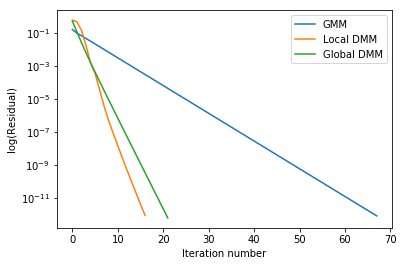

In [14]:
plt.semilogy(linear_gmg.get_gmg_convergence(),label = 'GMM')
plt.semilogy(deep_gmm.get_gmg_convergence(),label= 'Local DMM')
plt.semilogy(DMM_Res,label= 'Global DMM')
plt.xlabel("Iteration number")
plt.ylabel("log(Residual)")
plt.legend()